# Primera Parte: Análisis Cuantitativo

1.1	Primer examen preliminar del dataset.  ¿En qué formato está el dataset y qué tiene que ver este formato con Big Data? ¿Qué parámetros hay en el dataset? ¿Cuál es su significado? ¿Existen valores aparentemente incorrectos?

## Dependencias, obtención y carga de datos NYC Taxi

### Instalar los paquetes necesarios, ejecutar solo al principio.

In [1]:
# 📦 Instalar paquetes necesarios
%pip install pandas numpy pyarrow matplotlib seaborn plotly nbformat scipy scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Importar librerías

In [2]:
# 📦 Imports principales para análisis de datos y visualización

# Carga y manipulación de datos
import pandas as pd       # type: ignore # Manipulación y análisis de datos tabulares
import numpy as np        # type: ignore # Operaciones numéricas (opcional, pero útil)

# Lectura de archivos Parquet
import pyarrow.parquet as pq  # type: ignore # Backend recomendado para parquet (alternativa: fastparquet)

# Visualización básica y exploratoria
import matplotlib.pyplot as plt      # type: ignore # Visualizaciones estándar (histogramas, scatter, etc.)
import seaborn as sns                # type: ignore # Visualización estadística avanzada (heatmaps, countplots)

# Visualización avanzada 
import plotly.express as px         # type: ignore # Visualizaciones interactivas (incl. Sankey, mapas, etc.)
import plotly.graph_objects as go # type: ignore # Gráficos más complejos y personalizados

# Configuración general de visualizaciones
plt.style.use('seaborn-v0_8')        # Estilo visual estándar
# %matplotlib inline                   # Para visualizar directamente en el notebook

# Para calcular el z-score de las columnas numéricas
from scipy.stats import zscore # type: ignore

# Para manejar rutas de archivos y directorios
import os

# linear models para regresión
from sklearn.linear_model import RANSACRegressor, LinearRegression # type: ignore



### Carga los nombres de zona desde taxi_zone_lookup.csv en zona_nombres

In [3]:
def get_zona_nombres():
    """
    Devuelve un diccionario {LocationID: Zone} con los nombres de zona de NYC.
    1. Si el archivo local 'datasets/taxi_zone_lookup.csv' existe, lo carga desde ahí.
    2. Si no existe, lo descarga de la URL y lo guarda localmente para futuras ejecuciones.
    """
    local_path = "datasets/taxi_zone_lookup.csv"
    url_lookup = "https://raw.githubusercontent.com/renerubio/NYC-TAXI/refs/heads/main/taxi_zone_lookup.csv"

    if os.path.exists(local_path):
        taxi_zones = pd.read_csv(local_path)
        print("Cargado desde archivo local.")
    else:
        taxi_zones = pd.read_csv(url_lookup)
        print("Cargado desde URL.")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        taxi_zones.to_csv(local_path, index=False)
        print(f"Guardado en {local_path}.")

    return taxi_zones.set_index("LocationID")["Zone"].to_dict()

# Cargar diccionario
zona_nombres = get_zona_nombres()


Cargado desde archivo local.


### Importar y cargar ficheros parquet

In [4]:
# Función reutilizable para cargar Parquet desde local o URL
def cargar_parquet_local_o_url(local_path: str, url: str) -> pd.DataFrame:
    import os
    import pandas as pd

    if os.path.exists(local_path):
        print(f"✅ Cargado desde archivo local: {local_path}")
    else:
        print(f"🌐 Descargando desde URL: {url}")
        df = pd.read_parquet(url, engine="pyarrow")
        os.makedirs(os.path.dirname(local_path), exist_ok=True)
        df.to_parquet(local_path, engine="pyarrow", index=False)
        print(f"💾 Guardado en {local_path}")
        return df

    return pd.read_parquet(local_path, engine="pyarrow")

# Ruta base de trip-data
data_path = "https://d37ci6vzurychx.cloudfront.net/trip-data/"

# Diccionario de datasets y sus rutas
datasets_parquet = {
    "yellow_df_2025_02": ("datasets/yellow_tripdata_2025-02.parquet", data_path + "yellow_tripdata_2025-02.parquet"),
    "green_df_2025_02":  ("datasets/green_tripdata_2025-02.parquet",  data_path + "green_tripdata_2025-02.parquet"),
    "fhv_df_2025_02":    ("datasets/fhv_tripdata_2025-02.parquet",    data_path + "fhv_tripdata_2025-02.parquet"),
    "fhvhv_df_2025_02":  ("datasets/fhvhv_tripdata_2025-02.parquet",  data_path + "fhvhv_tripdata_2025-02.parquet"),
    "yellow_df_2024_12": ("datasets/yellow_tripdata_2024-12.parquet", data_path + "yellow_tripdata_2024-12.parquet"),
    "green_df_2024_12":  ("datasets/green_tripdata_2024-12.parquet",  data_path + "green_tripdata_2024-12.parquet"),
    "fhv_df_2024_12":    ("datasets/fhv_tripdata_2024-12.parquet",    data_path + "fhv_tripdata_2024-12.parquet"),
    "fhvhv_df_2024_12":  ("datasets/fhvhv_tripdata_2024-12.parquet",  data_path + "fhvhv_tripdata_2024-12.parquet")
}

# Cargar todos los datasets
for nombre, (ruta_local, url_remota) in datasets_parquet.items():
    globals()[nombre] = cargar_parquet_local_o_url(ruta_local, url_remota)


✅ Cargado desde archivo local: datasets/yellow_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/green_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/fhv_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/fhvhv_tripdata_2025-02.parquet
✅ Cargado desde archivo local: datasets/yellow_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/green_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/fhv_tripdata_2024-12.parquet
✅ Cargado desde archivo local: datasets/fhvhv_tripdata_2024-12.parquet


#### Verificación de la carga de los datasets de Febrero 2025

In [5]:
# Mostramos el número de filas y columnas de cada dataset de Febrero 2025
for name, df in zip(["Yellow", "Green", "FHV", "FHVHV"],
                    [yellow_df_2025_02, green_df_2025_02, fhv_df_2025_02, fhvhv_df_2025_02]): # type: ignore
    print(f"{name} Cabs February 2025: {df.shape[0]:,} filas, {df.shape[1]} columnas")

Yellow Cabs February 2025: 3,577,543 filas, 20 columnas
Green Cabs February 2025: 46,621 filas, 21 columnas
FHV Cabs February 2025: 1,578,722 filas, 7 columnas
FHVHV Cabs February 2025: 19,339,461 filas, 25 columnas


#### Verificación de la carga de los datasets de Diciembre 2024

In [6]:
# Mostramos el número de filas y columnas de cada dataset de Diciembre 2024
for name, df in zip(["Yellow", "Green", "FHV", "FHVHV"],
                    [yellow_df_2024_12, green_df_2024_12, fhv_df_2024_12, fhvhv_df_2024_12]): # type: ignore
    print(f"{name} Cabs December 2024: {df.shape[0]:,} filas, {df.shape[1]} columnas")

Yellow Cabs December 2024: 3,668,371 filas, 19 columnas
Green Cabs December 2024: 53,994 filas, 20 columnas
FHV Cabs December 2024: 1,913,200 filas, 7 columnas
FHVHV Cabs December 2024: 21,068,851 filas, 24 columnas


### Objeto global con los datasets cargados y listos para usar 

In [7]:
# Definimos todos los datasets con sus nombres
datasets = {
    "Yellow Feb 2025": yellow_df_2025_02, # type: ignore
    "Green Feb 2025": green_df_2025_02, # type: ignore
    "FHV Feb 2025": fhv_df_2025_02, # type: ignore
    "FHVHV Feb 2025": fhvhv_df_2025_02, # type: ignore
    "Yellow Dec 2024": yellow_df_2024_12, # type: ignore
    "Green Dec 2024": green_df_2024_12, # type: ignore
    "FHV Dec 2024": fhv_df_2024_12, # type: ignore
    "FHVHV Dec 2024": fhvhv_df_2024_12 # type: ignore
}

## Análisis de datos

### Presencia de columnas en cada dataset

In [8]:
# Obtenemos todas las columnas únicas
all_columns = set()
for df in datasets.values():
    all_columns.update(df.columns)

# Calculamos frecuencia de cada columna (en cuántos datasets aparece)
column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

# Ordenamos columnas por frecuencia (mayor a menor) y luego alfabéticamente
sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

# Creamos la tabla de presencia
presence_data = []
for name, df in datasets.items():
    presence_data.append([name] + ['Sí' if col in df.columns else 'No' for col in sorted_columns])

# Creamos el DataFrame
presence_df = pd.DataFrame(presence_data, columns=['Dataset'] + sorted_columns)

# Mostramos la tabla
print("Presencia de columnas en cada dataset (ordenadas por frecuencia):")
print(presence_df.to_string(index=False))



Presencia de columnas en cada dataset (ordenadas por frecuencia):
        Dataset DOLocationID PULocationID congestion_surcharge RatecodeID VendorID dispatching_base_num extra fare_amount improvement_surcharge mta_tax passenger_count payment_type pickup_datetime store_and_fwd_flag tip_amount tolls_amount total_amount trip_distance cbd_congestion_fee Affiliated_base_number Airport_fee DOlocationID PUlocationID SR_Flag access_a_ride_flag airport_fee base_passenger_fare bcf driver_pay dropOff_datetime dropoff_datetime ehail_fee hvfhs_license_num lpep_dropoff_datetime lpep_pickup_datetime on_scene_datetime originating_base_num request_datetime sales_tax shared_match_flag shared_request_flag tips tolls tpep_dropoff_datetime tpep_pickup_datetime trip_miles trip_time trip_type wav_match_flag wav_request_flag
Yellow Feb 2025           Sí           Sí                   Sí         Sí       Sí                   No    Sí          Sí                    Sí      Sí              Sí           Sí       

### Obtener todas las columnas y su frecuencia

C:\Users\Intekmedical\AppData\Local\Temp\ipykernel_22592\2735549979.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  heatmap_df.replace({"Sí": 1, "No": 0}),  # Convertir a 1/0 para el color


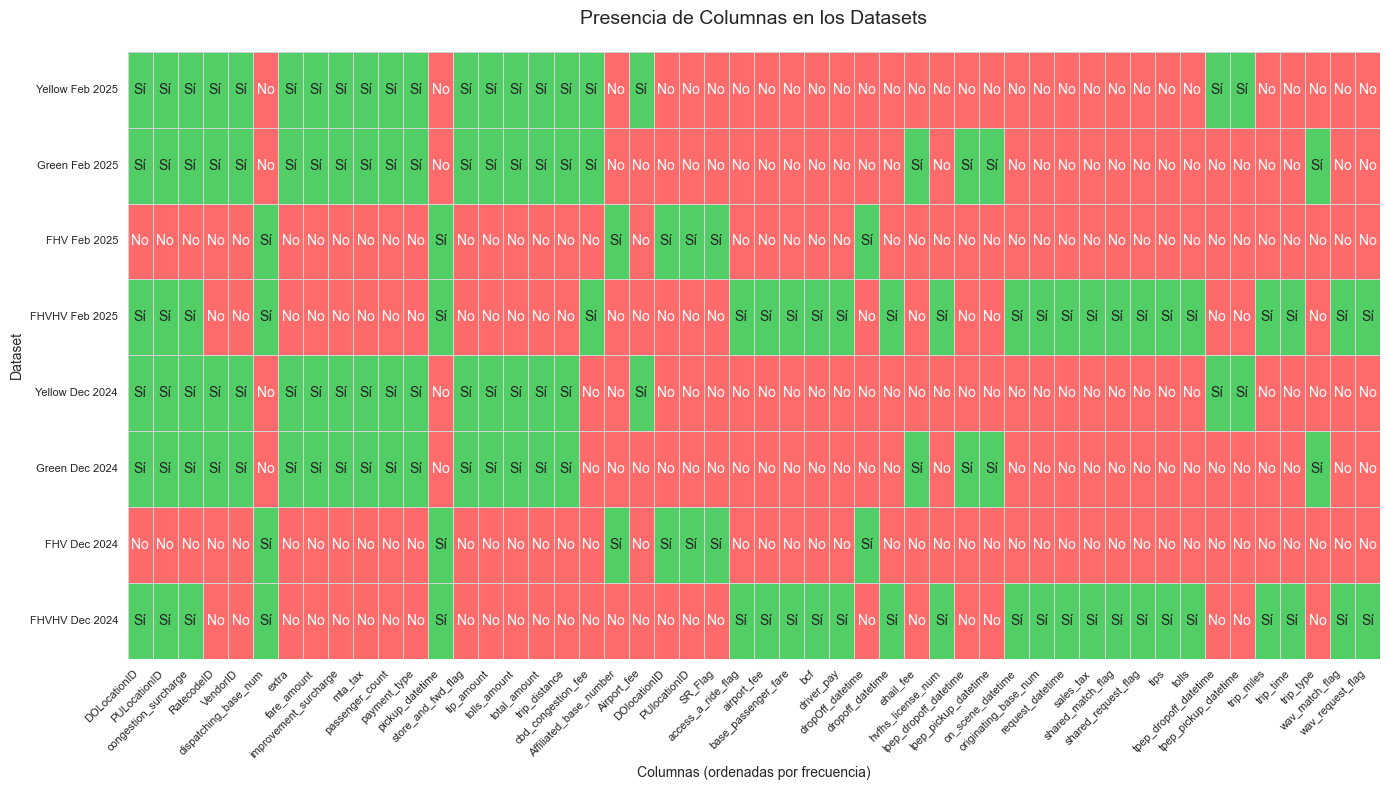

In [9]:

# 2. Obtener todas las columnas y su frecuencia
all_columns = set()
for df in datasets.values():
    all_columns.update(df.columns)
column_freq = {col: sum(col in df.columns for df in datasets.values()) for col in all_columns}

# 3. Ordenar columnas por frecuencia (de mayor a menor)
sorted_columns = sorted(all_columns, key=lambda x: (-column_freq[x], x))

# 4. Crear matriz de presencia (Sí/No)
presence_matrix = []
for name, df in datasets.items():
    presences = [1 if col in df.columns else 0 for col in sorted_columns]
    presences = ["Sí" if p == 1 else "No" for p in presences]
    presence_matrix.append(presences)

# 5. Crear DataFrame para el heatmap
heatmap_df = pd.DataFrame(
    presence_matrix,
    index=datasets.keys(),
    columns=sorted_columns
)

# 6. Configurar el gráfico
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_df.replace({"Sí": 1, "No": 0}),  # Convertir a 1/0 para el color
    cmap=["#FF6B6B", "#51CF66"],  # Rojo para "No", Verde para "Sí"
    linewidths=0.5,
    linecolor="lightgray",
    annot=heatmap_df.values,  # Mostrar "Sí"/"No"
    fmt="",
    cbar=False
)

# 7. Personalizar el gráfico
plt.title("Presencia de Columnas en los Datasets", fontsize=14, pad=20)
plt.xlabel("Columnas (ordenadas por frecuencia)", fontsize=10)
plt.ylabel("Dataset", fontsize=10)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

### Normalización de características

#### Objeto global `column_groups` son grupos de columnas equivalentes para normalización

In [ ]:
# Grupos de columnas equivalentes para normalización
column_groups = {
    # Columnas de ubicación
    'PULocationID': ['PUlocationID', 'PULocationID'],
    'DOLocationID': ['DOlocationID', 'DOLocationID'],
    
    # Columnas temporales
    'pickup_datetime': [
        'tpep_pickup_datetime', 
        'lpep_pickup_datetime',
        'pickup_datetime'
    ],
    'dropoff_datetime': [
        'tpep_dropoff_datetime',
        'lpep_dropoff_datetime',
        'dropOff_datetime',
        'dropoff_datetime',
        'on_scene_datetime'
    ],
    
    # Columnas de tarifas
    'airport_fee': ['Airport_fee', 'airport_fee'],
    
    # Columnas de pago
    'tolls': ['tolls_amount', 'tolls'],
    'tips': ['tip_amount', 'tips']
}

#### Vamos a normalizar los parámetros para tener uniformidad para los futuros análisis

In [11]:
# Definimos un mapeo de nombres de columnas estándar a sus variantes
def normalize_column_names(df, column_mapping):
    """
    Normaliza los nombres de columnas según el mapeo proporcionado.
    Si ya existe una columna con el nombre estándar, elimina las variantes para evitar duplicados.
    """
    df = df.copy()
    for standard_name, variants in column_mapping.items():
        for variant in variants:
            if variant in df.columns:
                if standard_name in df.columns and variant != standard_name:
                    # Si ya existe la estándar, eliminamos el duplicado para evitar conflicto
                    df.drop(columns=[variant], inplace=True)
                else:
                    df.rename(columns={variant: standard_name}, inplace=True)
    
    # Eliminar columnas duplicadas (por si acaso)
    df = df.loc[:, ~df.columns.duplicated()]
    return df

# Aplicar a todos los datasets
normalized_datasets = {}
for name, df in datasets.items():
    normalized_df = normalize_column_names(df, column_groups)
    normalized_datasets[name] = normalized_df

# Verificar columnas únicas después de normalizar
all_normalized_columns = set()
for df in normalized_datasets.values():
    all_normalized_columns.update(df.columns)

print("Columnas únicas después de normalizar:")
print(sorted(all_normalized_columns))

Columnas únicas después de normalizar:
['Affiliated_base_number', 'DOLocationID', 'PULocationID', 'RatecodeID', 'SR_Flag', 'VendorID', 'access_a_ride_flag', 'airport_fee', 'base_passenger_fare', 'bcf', 'cbd_congestion_fee', 'congestion_surcharge', 'dispatching_base_num', 'driver_pay', 'dropoff_datetime', 'ehail_fee', 'extra', 'fare_amount', 'hvfhs_license_num', 'improvement_surcharge', 'mta_tax', 'originating_base_num', 'passenger_count', 'payment_type', 'pickup_datetime', 'request_datetime', 'sales_tax', 'shared_match_flag', 'shared_request_flag', 'store_and_fwd_flag', 'tips', 'tolls', 'total_amount', 'trip_distance', 'trip_miles', 'trip_time', 'trip_type', 'wav_match_flag', 'wav_request_flag']


#### Verificación antes-después de la normalización de características

In [12]:
# Verificar columnas de un dataset específico
print("\nColumnas del dataset 'Yellow Feb 2025' antes de normalizar:")
print(datasets["Yellow Feb 2025"].columns)

print("\nColumnas del dataset 'Yellow Feb 2025' después de normalizar:")
print(normalized_datasets["Yellow Feb 2025"].columns)

# tabla de antes y después de normalizar
before_df_yellow = pd.DataFrame({
    'Antes': datasets["Yellow Feb 2025"].columns,
})
after_df_yellow = pd.DataFrame({
    'Después': normalized_datasets["Yellow Feb 2025"].columns
})
print("\nTabla de columnas antes y después de normalizar:")
print(before_df_yellow)
print(after_df_yellow)

# cuenta el número de columnas antes y después de normalizar
before_count = len(datasets["Yellow Feb 2025"].columns) 
after_count = len(normalized_datasets["Yellow Feb 2025"].columns)

print(f"\nNúmero de columnas antes de normalizar: {before_count}")
print(f"Número de columnas después de normalizar: {after_count}")


Columnas del dataset 'Yellow Feb 2025' antes de normalizar:
Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee'],
      dtype='object')

Columnas del dataset 'Yellow Feb 2025' después de normalizar:
Index(['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tips', 'tolls', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'airport_fee', 'cbd_congestion_fee'],
      dtype='object')

Tabla de columnas antes y después de normalizar:
                    Antes
0   

## Limpieza de Datos

### 1. Pasajeros = nulos, 0 o negativos.
Reemplaza los valores nulos o negativos en passenger_count por 0 en todos los datasets del diccionario.

In [13]:
def limpiar_pasajeros_invalidos_dict_a_cero(datasets_dict):
    """
    Reemplaza registros con passenger_count nulo o negativo por 0 en cada dataset de un diccionario.

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}

    Retorna:
        diccionario actualizado con los DataFrames corregidos
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()
        if "passenger_count" in df.columns:
            count_nulls = df["passenger_count"].isnull().sum()
            count_negativos = (df["passenger_count"] < 0).sum()

            df["passenger_count"] = df["passenger_count"].apply(
                lambda x: 0 if pd.isnull(x) or x < 0 else x
            )

            print(f"{nombre}: corregidos {count_nulls + count_negativos} valores nulos o negativos en 'passenger_count'.")
        else:
            print(f"{nombre}: columna 'passenger_count' no encontrada. No se modifica.")
        datasets_corregidos[nombre] = df

    return datasets_corregidos

normalized_datasets = limpiar_pasajeros_invalidos_dict_a_cero(normalized_datasets)
# Verificar el conteo de pasajeros después de la limpieza
for name, df in normalized_datasets.items():
    if "passenger_count" in df.columns:
        count_invalid = df["passenger_count"].isnull().sum() + (df["passenger_count"] < 0).sum()
        print(f"{name}: {count_invalid} valores nulos o negativos en 'passenger_count' después de la limpieza.")
    else:
        print(f"{name}: columna 'passenger_count' no encontrada.")


Yellow Feb 2025: corregidos 806937 valores nulos o negativos en 'passenger_count'.
Green Feb 2025: corregidos 2517 valores nulos o negativos en 'passenger_count'.
FHV Feb 2025: columna 'passenger_count' no encontrada. No se modifica.
FHVHV Feb 2025: columna 'passenger_count' no encontrada. No se modifica.
Yellow Dec 2024: corregidos 326291 valores nulos o negativos en 'passenger_count'.
Green Dec 2024: corregidos 1981 valores nulos o negativos en 'passenger_count'.
FHV Dec 2024: columna 'passenger_count' no encontrada. No se modifica.
FHVHV Dec 2024: columna 'passenger_count' no encontrada. No se modifica.
Yellow Feb 2025: 0 valores nulos o negativos en 'passenger_count' después de la limpieza.
Green Feb 2025: 0 valores nulos o negativos en 'passenger_count' después de la limpieza.
FHV Feb 2025: columna 'passenger_count' no encontrada.
FHVHV Feb 2025: columna 'passenger_count' no encontrada.
Yellow Dec 2024: 0 valores nulos o negativos en 'passenger_count' después de la limpieza.
Green

### 2. Distancia = nulos, 0 o negativos.
La función `limpiar_distancias_invalidas_optimizada` corrige o elimina las distancias nulas o no válidas (`≤ 0`) reemplazándolas por la media de trayectos válidos con la misma combinación de origen y destino (`PULocationID` → `DOLocationID`), siempre que haya suficientes registros similares. Si no hay suficientes, elimina el registro. Todo el proceso está optimizado para ejecutarse rápidamente incluso con grandes volúmenes de datos.
.

In [14]:
def limpiar_distancias_invalidas_optimizada(datasets_dict, min_similares=5):
    """
    Limpia registros con trip_distance <= 0 o nulos.
    Si existen trayectos con la misma combinación de PULocationID y DOLocationID suficientes,
    reemplaza por la media; si no, elimina el registro.

    Optimización: precomputa la media por combinación origen-destino una sola vez
    y evita iteraciones fila a fila.

    Retorna:
        diccionario actualizado con los DataFrames corregidos
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "trip_distance" not in df.columns or "PULocationID" not in df.columns or "DOLocationID" not in df.columns:
            print(f"{nombre}: columnas necesarias no encontradas. No se modifica.")
            datasets_corregidos[nombre] = df
            continue

        # Separar válidos y no válidos
        validos = df[df["trip_distance"].notnull() & (df["trip_distance"] > 0)]
        invalidos = df[~df.index.isin(validos.index)]

        # Calcular medias por origen-destino (solo si hay suficientes registros)
        conteo_por_par = validos.groupby(["PULocationID", "DOLocationID"]).size()
        pares_validos = conteo_por_par[conteo_por_par >= min_similares].index

        medias = validos.groupby(["PULocationID", "DOLocationID"])["trip_distance"].mean().reset_index()
        medias = medias[medias.set_index(["PULocationID", "DOLocationID"]).index.isin(pares_validos)]
        medias.rename(columns={"trip_distance": "trip_distance_media"}, inplace=True)

        # Unir con los inválidos
        invalidos_corregibles = invalidos.merge(medias, on=["PULocationID", "DOLocationID"], how="left")
        corregidos = invalidos_corregibles[invalidos_corregibles["trip_distance_media"].notnull()].copy()
        corregidos["trip_distance"] = corregidos["trip_distance_media"]
        corregidos.drop(columns=["trip_distance_media"], inplace=True)

        eliminados = invalidos_corregibles[invalidos_corregibles["trip_distance_media"].isnull()]

        # Combinar con los válidos
        df_final = pd.concat([validos, corregidos], ignore_index=True)

        print(f"{nombre}: {len(invalidos)} registros inválidos, {len(corregidos)} corregidos, {len(eliminados)} eliminados.")
        datasets_corregidos[nombre] = df_final

    return datasets_corregidos


normalized_datasets = limpiar_distancias_invalidas_optimizada(normalized_datasets)
# Verificar el conteo de distancias inválidas después de la limpieza
for name, df in normalized_datasets.items():
    if "trip_distance" in df.columns:
        count_invalid = df["trip_distance"].isnull().sum() + (df["trip_distance"] <= 0).sum()
        print(f"{name}: {count_invalid} valores nulos o negativos en 'trip_distance' después de la limpieza.")
    else:
        print(f"{name}: columna 'trip_distance' no encontrada.")


Yellow Feb 2025: 99771 registros inválidos, 97653 corregidos, 2118 eliminados.
Green Feb 2025: 2377 registros inválidos, 1346 corregidos, 1031 eliminados.
FHV Feb 2025: columnas necesarias no encontradas. No se modifica.
FHVHV Feb 2025: columnas necesarias no encontradas. No se modifica.
Yellow Dec 2024: 75450 registros inválidos, 73091 corregidos, 2359 eliminados.
Green Dec 2024: 3002 registros inválidos, 1666 corregidos, 1336 eliminados.
FHV Dec 2024: columnas necesarias no encontradas. No se modifica.
FHVHV Dec 2024: columnas necesarias no encontradas. No se modifica.
Yellow Feb 2025: 0 valores nulos o negativos en 'trip_distance' después de la limpieza.
Green Feb 2025: 0 valores nulos o negativos en 'trip_distance' después de la limpieza.
FHV Feb 2025: columna 'trip_distance' no encontrada.
FHVHV Feb 2025: columna 'trip_distance' no encontrada.
Yellow Dec 2024: 0 valores nulos o negativos en 'trip_distance' después de la limpieza.
Green Dec 2024: 0 valores nulos o negativos en 'tri

### 3.	Duración del Trayecto = nula, 0 o negativo

In [15]:
def limpiar_duracion_invalida_optimizada(datasets_dict, min_similares=5):
    """
    Limpia registros con duración del trayecto <= 0 minutos o nula.
    La duración se calcula como diferencia entre dropoff_datetime y pickup_datetime.
    Si existen trayectos con la misma combinación de PULocationID y DOLocationID suficientes,
    reemplaza por la media; si no, elimina el registro.

    Retorna:
        diccionario actualizado con los DataFrames corregidos
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Detectar nombres de columnas datetime
        if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
            pickup_col = 'pickup_datetime'
            dropoff_col = 'dropoff_datetime'
        else:
            print(f"{nombre}: columnas de fecha no encontradas. No se modifica.")
            datasets_corregidos[nombre] = df
            continue

        # Calcular duración si no existe
        if "trip_duration_min" not in df.columns:
            df['trip_duration_min'] = (
                pd.to_datetime(df[dropoff_col]) - pd.to_datetime(df[pickup_col])
            ).dt.total_seconds() / 60

        # Separar válidos y no válidos
        df_validos = df[df["trip_duration_min"].notnull() & (df["trip_duration_min"] > 0)]
        df_invalidos = df[~df.index.isin(df_validos.index)]

        # Agrupar trayectos válidos por origen-destino con mínimo de registros
        conteo_por_par = df_validos.groupby(["PULocationID", "DOLocationID"]).size()
        pares_validos = conteo_por_par[conteo_por_par >= min_similares].index

        medias = df_validos.groupby(["PULocationID", "DOLocationID"])["trip_duration_min"].mean().reset_index()
        medias = medias[medias.set_index(["PULocationID", "DOLocationID"]).index.isin(pares_validos)]
        medias.rename(columns={"trip_duration_min": "duracion_media"}, inplace=True)

        # Unir con los inválidos
        df_invalidos_corregibles = df_invalidos.merge(medias, on=["PULocationID", "DOLocationID"], how="left")
        corregidos = df_invalidos_corregibles[df_invalidos_corregibles["duracion_media"].notnull()].copy()
        corregidos["trip_duration_min"] = corregidos["duracion_media"]
        corregidos.drop(columns=["duracion_media"], inplace=True)

        eliminados = df_invalidos_corregibles[df_invalidos_corregibles["duracion_media"].isnull()]

        # Combinar con los válidos
        df_final = pd.concat([df_validos, corregidos], ignore_index=True)

        print(f"{nombre}: {len(df_invalidos)} registros inválidos de duración, {len(corregidos)} corregidos, {len(eliminados)} eliminados.")
        datasets_corregidos[nombre] = df_final

    return datasets_corregidos
normalized_datasets = limpiar_duracion_invalida_optimizada(normalized_datasets)
# Verificar el conteo de duraciones inválidas después de la limpieza
for name, df in normalized_datasets.items():
    if "trip_duration_min" in df.columns:
        count_invalid = df["trip_duration_min"].isnull().sum() + (df["trip_duration_min"] <= 0).sum()
        print(f"{name}: {count_invalid} valores nulos o negativos en 'trip_duration_min' después de la limpieza.")
    else:
        print(f"{name}: columna 'trip_duration_min' no encontrada.")

Yellow Feb 2025: 5114 registros inválidos de duración, 5082 corregidos, 32 eliminados.
Green Feb 2025: 240 registros inválidos de duración, 68 corregidos, 172 eliminados.
FHV Feb 2025: 285 registros inválidos de duración, 173 corregidos, 112 eliminados.
FHVHV Feb 2025: 4 registros inválidos de duración, 4 corregidos, 0 eliminados.
Yellow Dec 2024: 1181 registros inválidos de duración, 1144 corregidos, 37 eliminados.
Green Dec 2024: 40 registros inválidos de duración, 39 corregidos, 1 eliminados.
FHV Dec 2024: 0 registros inválidos de duración, 0 corregidos, 0 eliminados.


MemoryError: Unable to allocate 1.41 GiB for an array with shape (9, 21068848) and data type float64

### 4. Importe Total nulo, o <= 0 
Esta función corrige registros cuyo importe total (total_amount) sea nulo o menor o igual a 0. Reemplaza el valor usando la media de trayectos similares (misma zona origen y destino), si hay suficientes. Si no hay datos similares, elimina el registro.

In [ ]:
def limpiar_total_amount_invalido_optimizada(datasets_dict, min_similares=5):
    """
    Corrige registros con 'total_amount' nulo o <= 0 si hay trayectos similares con la misma zona.
    Si no hay suficientes trayectos válidos, elimina el registro.
    Aplica la limpieza solo si la columna 'total_amount' está presente en el dataset.
    """
    datasets_corregidos = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        if "total_amount" not in df.columns:
            print(f"🟡 Aviso: '{nombre}' no contiene la columna 'total_amount'. Se omite la limpieza.")
            datasets_corregidos[nombre] = df
            continue

        # Separar válidos e inválidos
        df_validos = df[df["total_amount"].notnull() & (df["total_amount"] > 0)].copy()
        df_invalidos = df[df["total_amount"].isnull() | (df["total_amount"] <= 0)].copy()

        # Agrupar válidos por combinación PU-DO y calcular media
        medias = (
            df_validos.groupby(["PULocationID", "DOLocationID"])["total_amount"]
            .agg(["mean", "count"])
            .reset_index()
        )

        # Diccionario para acceso rápido
        media_dict = {
            (row["PULocationID"], row["DOLocationID"]): (row["mean"], row["count"])
            for _, row in medias.iterrows()
        }

        corregidos = []
        for _, row in df_invalidos.iterrows():
            key = (row["PULocationID"], row["DOLocationID"])
            if key in media_dict and media_dict[key][1] >= min_similares:
                nuevo = row.copy()
                nuevo["total_amount"] = media_dict[key][0]
                corregidos.append(nuevo)

        # Dataset final: válidos + corregidos
        df_final = pd.concat([df_validos, pd.DataFrame(corregidos)], ignore_index=True)
        datasets_corregidos[nombre] = df_final

    return datasets_corregidos

# Aplicar la limpieza de total_amount
normalized_datasets = limpiar_total_amount_invalido_optimizada(normalized_datasets)

# Verificar el conteo de total_amount inválidos después de la limpieza
for name, df in normalized_datasets.items():
    if "total_amount" in df.columns:
        count_invalid = df["total_amount"].isnull().sum() + (df["total_amount"] <= 0).sum()
        print(f"{name}: {count_invalid} valores nulos o negativos en 'total_amount' después de la limpieza.")
    else:
        print(f"{name}: columna 'total_amount' no encontrada.")


🟡 Aviso: 'FHV Feb 2025' no contiene la columna 'total_amount'. Se omite la limpieza.
🟡 Aviso: 'FHVHV Feb 2025' no contiene la columna 'total_amount'. Se omite la limpieza.
🟡 Aviso: 'FHV Dec 2024' no contiene la columna 'total_amount'. Se omite la limpieza.
🟡 Aviso: 'FHVHV Dec 2024' no contiene la columna 'total_amount'. Se omite la limpieza.
Yellow Feb 2025: 0 valores nulos o negativos en 'total_amount' después de la limpieza.
Green Feb 2025: 0 valores nulos o negativos en 'total_amount' después de la limpieza.
FHV Feb 2025: columna 'total_amount' no encontrada.
FHVHV Feb 2025: columna 'total_amount' no encontrada.
Yellow Dec 2024: 0 valores nulos o negativos en 'total_amount' después de la limpieza.
Green Dec 2024: 0 valores nulos o negativos en 'total_amount' después de la limpieza.
FHV Dec 2024: columna 'total_amount' no encontrada.
FHVHV Dec 2024: columna 'total_amount' no encontrada.


### 5.	PULocationID y DOLocationID inválidos según el Taxi_Zone_Lookup

Script optimizado para añadir una columna location_valid a cada dataset en normalized_datasets, que marca con True los registros con PULocationID y DOLocationID válidos (presentes en el archivo oficial taxi_zone_lookup.csv), y False en caso contrario.

In [ ]:
def marcar_location_validos(datasets_dict):
    """
    Añade una columna 'location_valid' a cada dataset.
    Marca si el PULocationID y DOLocationID existen en el archivo oficial taxi_zone_lookup.csv.
    """
    # Leer zona válidas desde el CSV oficial
    zonas_validas = set(zona_nombres.keys())  # ✅ obtienes todos los LocationID válidos

    datasets_actualizados = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Comprobar si las columnas existen
        if "PULocationID" in df.columns and "DOLocationID" in df.columns:
            df["location_valid"] = df["PULocationID"].isin(zonas_validas) & df["DOLocationID"].isin(zonas_validas)
        else:
            print(f"🟡 Aviso: '{nombre}' no tiene columnas PU/DO LocationID. Se omite 'location_valid'.")
            df["location_valid"] = pd.NA

        datasets_actualizados[nombre] = df

    return datasets_actualizados

# Aplicar la función a los datasets normalizados
normalized_datasets = marcar_location_validos(normalized_datasets)
# Verificar la nueva columna
for name, df in normalized_datasets.items():
    if "location_valid" in df.columns:
        count_invalid = (~df["location_valid"]).sum()
        print(f"{name}: {count_invalid} registros con PULocationID o DOLocationID inválidos.")
    else:
        print(f"{name}: columna 'location_valid' no encontrada.")



Yellow Feb 2025: 0 registros con PULocationID o DOLocationID inválidos.
Green Feb 2025: 0 registros con PULocationID o DOLocationID inválidos.
FHV Feb 2025: 1275884 registros con PULocationID o DOLocationID inválidos.
FHVHV Feb 2025: 0 registros con PULocationID o DOLocationID inválidos.
Yellow Dec 2024: 0 registros con PULocationID o DOLocationID inválidos.
Green Dec 2024: 0 registros con PULocationID o DOLocationID inválidos.
FHV Dec 2024: 1674679 registros con PULocationID o DOLocationID inválidos.
FHVHV Dec 2024: 0 registros con PULocationID o DOLocationID inválidos.


### 6. Limpia si el origen y destino es el mismo o si alguno es inválido

In [ ]:
def eliminar_trayectos_invalidos(datasets_dict):
    """
    Elimina registros donde:
    - PULocationID == DOLocationID (trayecto inválido)
    - PULocationID o DOLocationID son nulos o están fuera del rango 1-263

    Parámetros:
        datasets_dict: diccionario {nombre_dataset: DataFrame}

    Retorna:
        diccionario actualizado con los DataFrames filtrados
    """
    datasets_filtrados = {}

    for nombre, df in datasets_dict.items():
        df = df.copy()

        # Condiciones inválidas
        condicion_igual = df["PULocationID"] == df["DOLocationID"]
        condicion_nula = df["PULocationID"].isna() | df["DOLocationID"].isna()

        registros_invalidos = df[condicion_igual | condicion_nula]
        df_filtrado = df.drop(index=registros_invalidos.index)

        print(f"{nombre}: eliminados {len(registros_invalidos)} registros inválidos (origen/destino).")

        datasets_filtrados[nombre] = df_filtrado.reset_index(drop=True)

    return datasets_filtrados

# Aplicar la función a los datasets normalizados
normalized_datasets = eliminar_trayectos_invalidos(normalized_datasets)


Yellow Feb 2025: eliminados 0 registros inválidos (origen/destino).
Green Feb 2025: eliminados 0 registros inválidos (origen/destino).
FHV Feb 2025: eliminados 1296808 registros inválidos (origen/destino).
FHVHV Feb 2025: eliminados 1473302 registros inválidos (origen/destino).
Yellow Dec 2024: eliminados 0 registros inválidos (origen/destino).
Green Dec 2024: eliminados 0 registros inválidos (origen/destino).
FHV Dec 2024: eliminados 1701015 registros inválidos (origen/destino).
FHVHV Dec 2024: eliminados 1583684 registros inválidos (origen/destino).


### Guardar los datasets normalizados y limpios en disco

In [ ]:
def guardar_datasets_parquet(datasets_dict, carpeta_destino="datasets_limpios"):
    """
    Guarda los datasets en formato .parquet dentro de la carpeta especificada.
    
    Args:
        datasets_dict (dict): Diccionario con nombre -> DataFrame
        carpeta_destino (str): Nombre de la carpeta donde guardar los ficheros
    """
    os.makedirs(carpeta_destino, exist_ok=True)

    for nombre, df in datasets_dict.items():
        nombre_limpio = nombre.replace(" ", "_").lower()
        ruta = os.path.join(carpeta_destino, f"{nombre_limpio}.parquet")
        df.to_parquet(ruta, index=False)
        print(f"✅ Guardado: {ruta}")

# Guardar los datasets normalizados en parquet
guardar_datasets_parquet(normalized_datasets)



✅ Guardado: datasets_limpios\fhvhv_dec_2024.parquet
✅ Guardado: datasets_limpios\fhvhv_feb_2025.parquet
✅ Guardado: datasets_limpios\fhv_dec_2024.parquet
✅ Guardado: datasets_limpios\fhv_feb_2025.parquet
✅ Guardado: datasets_limpios\green_dec_2024.parquet
✅ Guardado: datasets_limpios\green_feb_2025.parquet
✅ Guardado: datasets_limpios\yellow_dec_2024.parquet
✅ Guardado: datasets_limpios\yellow_feb_2025.parquet


### Cargar todos los datasets .parquet limpios en un diccionario normalized_datasets

In [ ]:
def cargar_datasets_parquet(carpeta="datasets_limpios"):
    """
    Carga los archivos .parquet uno a uno desde la carpeta especificada
    y los guarda en un diccionario con nombres legibles.

    Evita problemas de memoria al no cargar todos simultáneamente.
    """
    datasets = {}
    for archivo in os.listdir(carpeta):
        if archivo.endswith(".parquet"):
            nombre_dataset = archivo.replace(".parquet", "").replace("_", " ").title()
            ruta = os.path.join(carpeta, archivo)
            try:
                print(f"📥 Cargando: {nombre_dataset}")
                df = pd.read_parquet(ruta)
                datasets[nombre_dataset] = df
            except Exception as e:
                print(f"⚠️ Error al cargar {nombre_dataset}: {e}")
    return datasets


# Cargar los datasets normalizados desde parquet
normalized_datasets = cargar_datasets_parquet()
# Verificar la carga
for name, df in normalized_datasets.items():
    print(f"{name}: {df.shape[0]:,} filas, {df.shape[1]} columnas")


📥 Cargando: Fhvhv Dec 2024
📥 Cargando: Fhvhv Feb 2025
📥 Cargando: Fhv Dec 2024
📥 Cargando: Fhv Feb 2025
📥 Cargando: Green Dec 2024
📥 Cargando: Green Feb 2025
📥 Cargando: Yellow Dec 2024
📥 Cargando: Yellow Feb 2025
Fhvhv Dec 2024: 21,068,851 filas, 22 columnas
Fhvhv Feb 2025: 19,339,461 filas, 23 columnas
Fhv Dec 2024: 1,913,200 filas, 8 columnas
Fhv Feb 2025: 1,578,610 filas, 8 columnas
Green Dec 2024: 46,194 filas, 23 columnas
Green Feb 2025: 39,979 filas, 24 columnas
Yellow Dec 2024: 3,458,071 filas, 22 columnas
Yellow Feb 2025: 3,399,423 filas, 23 columnas


### Mostrar los nombres disponibles en el diccionario `normalized_dataset`

In [22]:
# Mostrar lista de columnas y sus tipos del dataset Yellow Cabs
yellow_columns_info = pd.DataFrame({
    'Columna': normalized_datasets["Yellow Feb 2025"].columns,
    'Tipo de dato': normalized_datasets["Yellow Feb 2025"].dtypes.astype(str)
})

# Mostrar la tabla
yellow_columns_info


,Columna,Tipo de dato
VendorID,VendorID,int64
pickup_datetime,pickup_datetime,datetime64[ns]
dropoff_datetime,dropoff_datetime,datetime64[ns]
passenger_count,passenger_count,float64
trip_distance,trip_distance,float64
RatecodeID,RatecodeID,float64
store_and_fwd_flag,store_and_fwd_flag,object
PULocationID,PULocationID,int64
DOLocationID,DOLocationID,int64
payment_type,payment_type,int64


### ¿Existen valores aparentemente incorrectos?  Yellow Cabs Febrero 2025

In [23]:
# Análisis de calidad de datos en Yellow Cabs (Febrero 2025)

def analizar_valores_invalidos(df):
    resultados = {}

    # Verificamos si alguna columna del grupo existe en el dataframe
    def get_first_existing(group):
        return next((col for col in group if col in df.columns), None)

    col_passengers = 'passenger_count' if 'passenger_count' in df.columns else None
    col_distance = 'trip_distance' if 'trip_distance' in df.columns else None
    col_total = 'total_amount' if 'total_amount' in df.columns else None

    col_pu = get_first_existing(column_groups['PULocationID'])
    col_do = get_first_existing(column_groups['DOLocationID'])
    col_pickup = get_first_existing(column_groups['pickup_datetime'])
    col_dropoff = get_first_existing(column_groups['dropoff_datetime'])

    # 1. Pasajeros
    if col_passengers:
        resultados['Pasajeros = nulos'] = df[col_passengers].isna().sum()
        resultados['Pasajeros < 0'] = (df[col_passengers] < 0).sum()

    # 2. Distancia
    if col_distance:
        resultados['Distancia = nula'] = df[col_distance].isna().sum()
        resultados['Distancia <= 0'] = (df[col_distance] <= 0).sum()

    # 3 y 4. Duración inválida
    if col_pickup and col_dropoff:
        pickup = pd.to_datetime(df[col_pickup], errors='coerce')
        dropoff = pd.to_datetime(df[col_dropoff], errors='coerce')
        resultados['Pickup/dropoff = nulos'] = pickup.isna().sum() + dropoff.isna().sum()
        resultados['Dropoff < Pickup'] = (dropoff < pickup).sum()
        resultados['Duración = 0 min'] = (dropoff == pickup).sum()

    # 5. Total
    if col_total:
        resultados['Total_amount = nulo'] = df[col_total].isna().sum()
        resultados['Total_amount <= 0'] = (df[col_total] <= 0).sum()

    # 6. Ubicaciones
    if col_pu:
        resultados['PULocationID = nulo'] = df[col_pu].isna().sum()
        resultados['PULocationID fuera de rango'] = df[~df[col_pu].between(1, 263)].shape[0]
    if col_do:
        resultados['DOLocationID = nulo'] = df[col_do].isna().sum()
        resultados['DOLocationID fuera de rango'] = df[~df[col_do].between(1, 263)].shape[0]

    return pd.DataFrame.from_dict(resultados, orient='index', columns=['Nº de registros'])



#### Análisis antes de la normalización y limpieza del dataset `Yellow Feb 2025`

In [24]:
# Ejecutamos el análisis en el dataset de Yellow Cabs antes de la limpieza
analizar_valores_invalidos(yellow_df_2025_02)

,Nº de registros
Pasajeros = nulos,806937
Pasajeros < 0,0
Distancia = nula,0
Distancia <= 0,99771
Pickup/dropoff = nulos,0
Dropoff < Pickup,93
Duración = 0 min,5071
Total_amount = nulo,0
Total_amount <= 0,55621
PULocationID = nulo,0


#### Análisis después de la normalización y limpieza del dataset `Yellow Feb 2025`

In [25]:
# Ejecutamos el análisis en el dataset de Yellow Cabs después de la limpieza
analizar_valores_invalidos(normalized_datasets["Yellow Feb 2025"])

,Nº de registros
Pasajeros = nulos,0
Pasajeros < 0,0
Distancia = nula,0
Distancia <= 0,0
Pickup/dropoff = nulos,0
Dropoff < Pickup,73
Duración = 0 min,5009
Total_amount = nulo,0
Total_amount <= 0,0
PULocationID = nulo,0


#### Gráfico combinado para representar de forma clara y visual los outliers en las variables más propensas a errores

In [26]:
def comparar_distribucion_viajes(df, nombre="Dataset"):
    """
    Visualiza histogramas y boxplots de distancia y duración del trayecto.
    Parámetros:
    - df: DataFrame con columnas 'trip_distance', 'tpep_pickup_datetime' y 'tpep_dropoff_datetime'
    - nombre: título del dataset para los gráficos
    """
    df = df.copy()

    # Calcular duración si no existe
    if "trip_duration_min" not in df.columns:
        if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
            df['trip_duration_min'] = (
                pd.to_datetime(df['tpep_dropoff_datetime'], errors='coerce') -
                pd.to_datetime(df['tpep_pickup_datetime'], errors='coerce')
            ).dt.total_seconds() / 60

    # Configuración general
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f"Comparativa de trayectos – {nombre}", fontsize=16)

    # 1. Histograma de distancias (hasta 20 millas)
    sns.histplot(df[df["trip_distance"] < 20]["trip_distance"], 
                 bins=50, kde=False, ax=axs[0, 0], color='steelblue')
    axs[0, 0].set_title("Distribución de distancias (< 20 millas)")
    axs[0, 0].set_xlabel("Distancia (millas)")

    # 2. Boxplot de distancias
    sns.boxplot(x=df[df["trip_distance"] < 20]["trip_distance"], 
                ax=axs[0, 1], color='skyblue')
    axs[0, 1].set_title("Boxplot de distancias (< 20 millas)")
    axs[0, 1].set_xlabel("Distancia (millas)")

    # 3. Histograma de duración (< 60 min)
    sns.histplot(df[df["trip_duration_min"] < 60]["trip_duration_min"], 
                 bins=50, kde=False, ax=axs[1, 0], color='darkorange')
    axs[1, 0].set_title("Distribución de duración (< 60 min)")
    axs[1, 0].set_xlabel("Duración (minutos)")

    # 4. Boxplot de duración
    sns.boxplot(x=df[df["trip_duration_min"] < 60]["trip_duration_min"], 
                ax=axs[1, 1], color='orange')
    axs[1, 1].set_title("Boxplot de duración (< 60 min)")
    axs[1, 1].set_xlabel("Duración (minutos)")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # espacio para título
    plt.show()



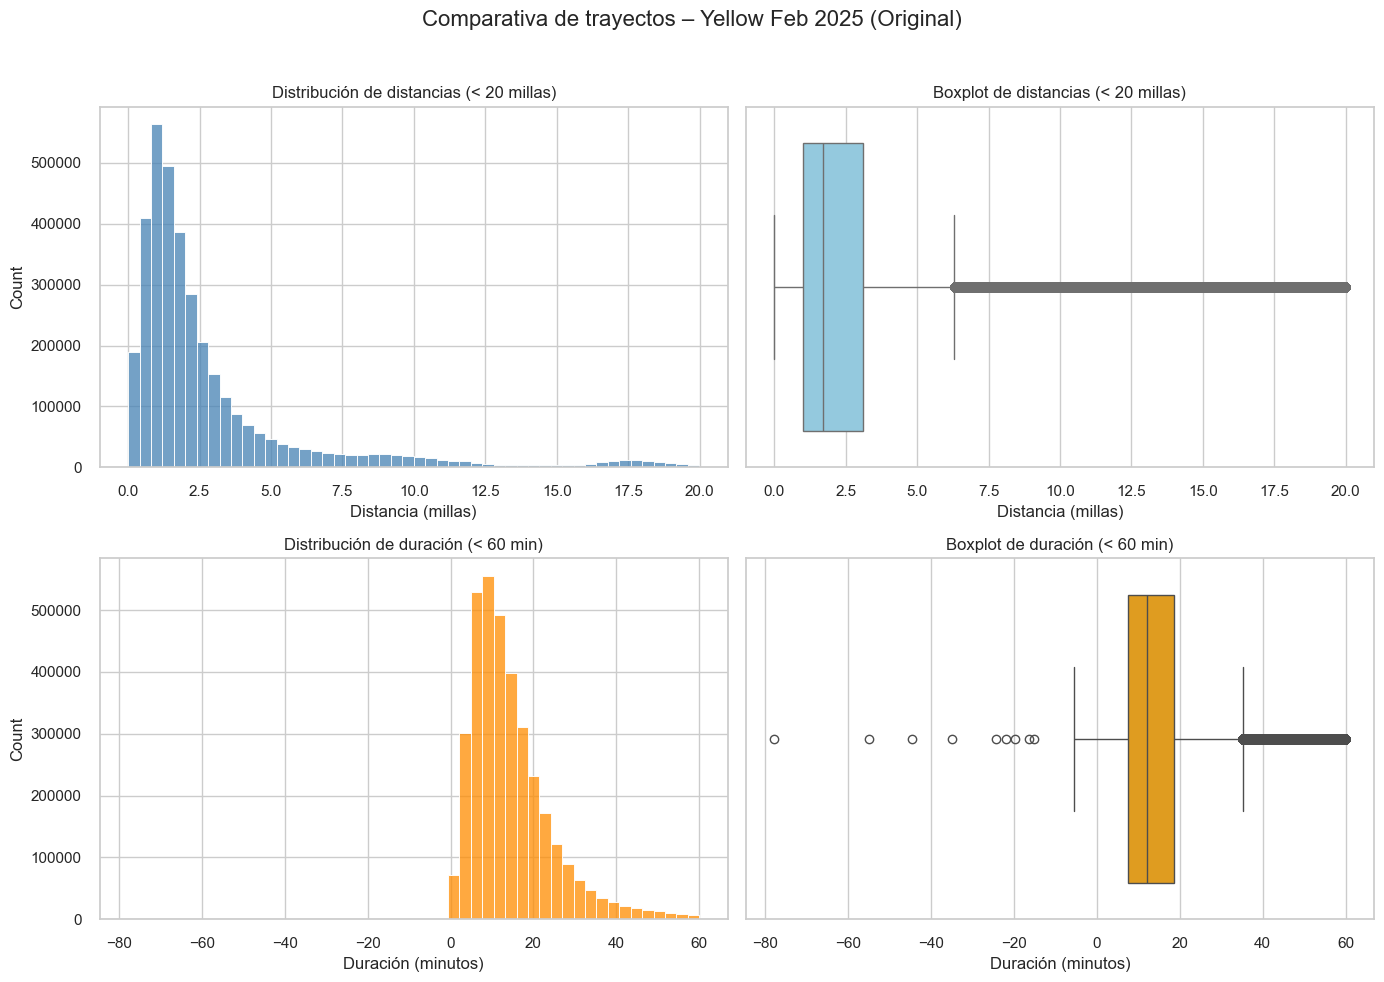

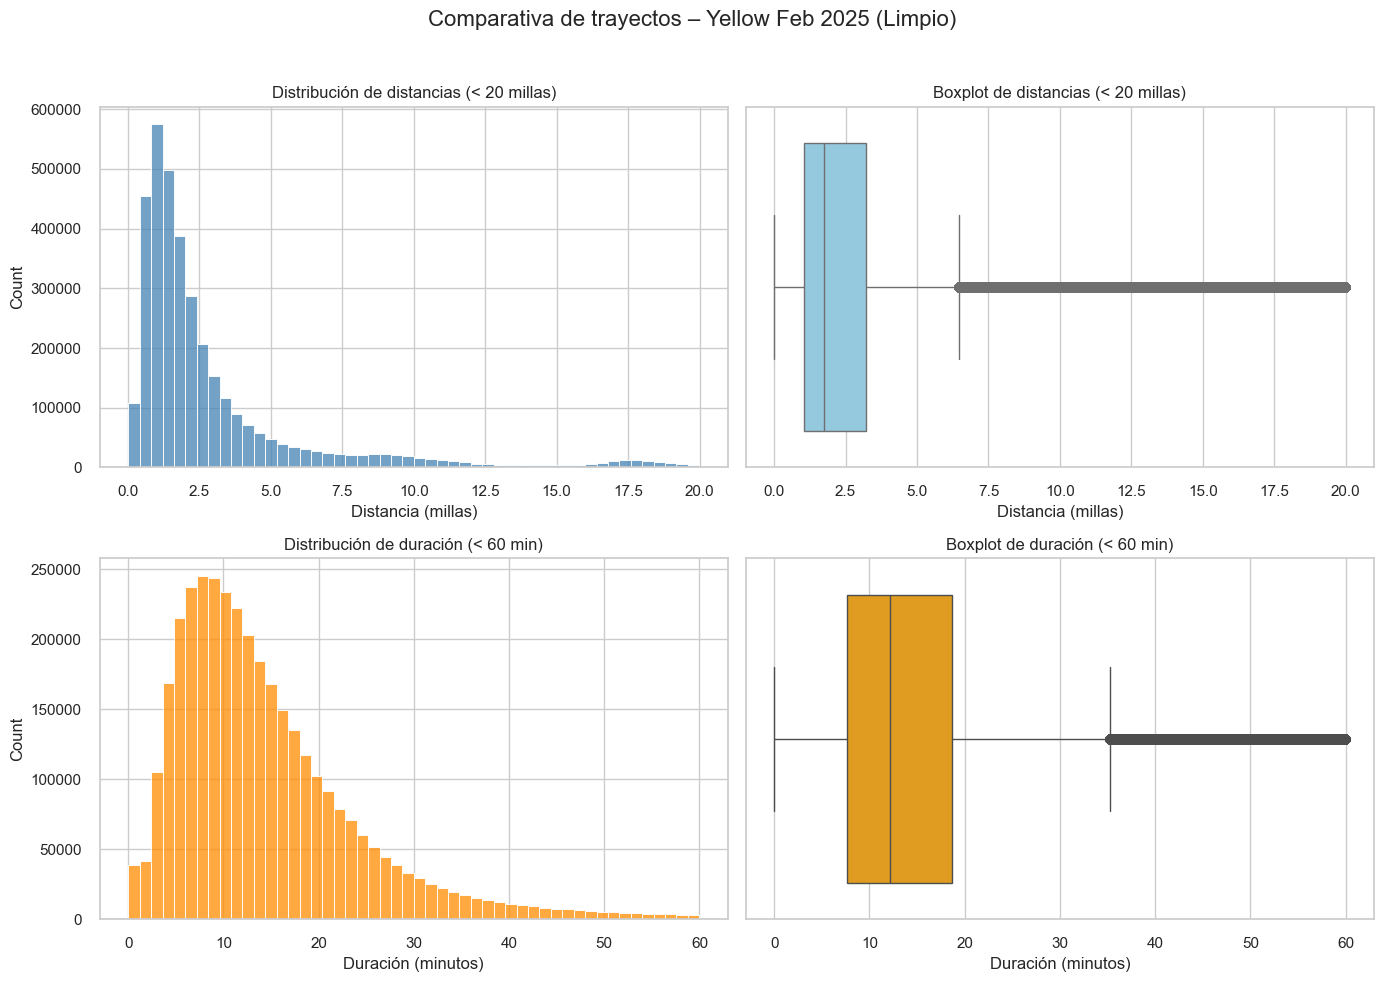

In [27]:
comparar_distribucion_viajes(yellow_df_2025_02, nombre="Yellow Feb 2025 (Original)")
comparar_distribucion_viajes(normalized_datasets["Yellow Feb 2025"], nombre="Yellow Feb 2025 (Limpio)")


### Visualización de trayectos entre las 20 zonas más activas

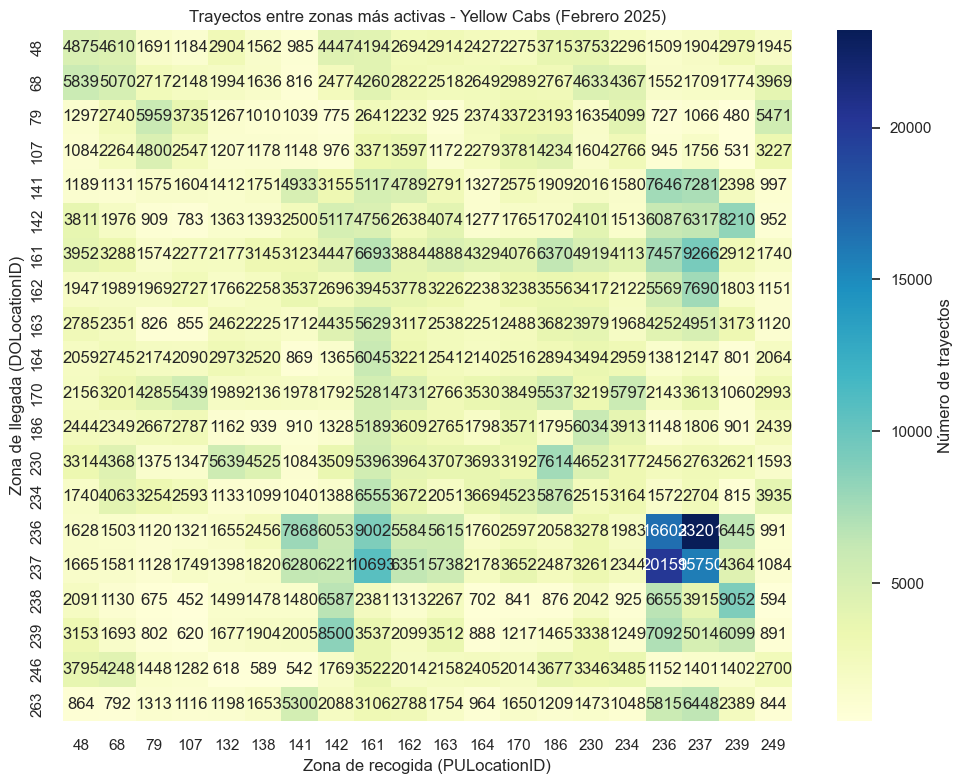

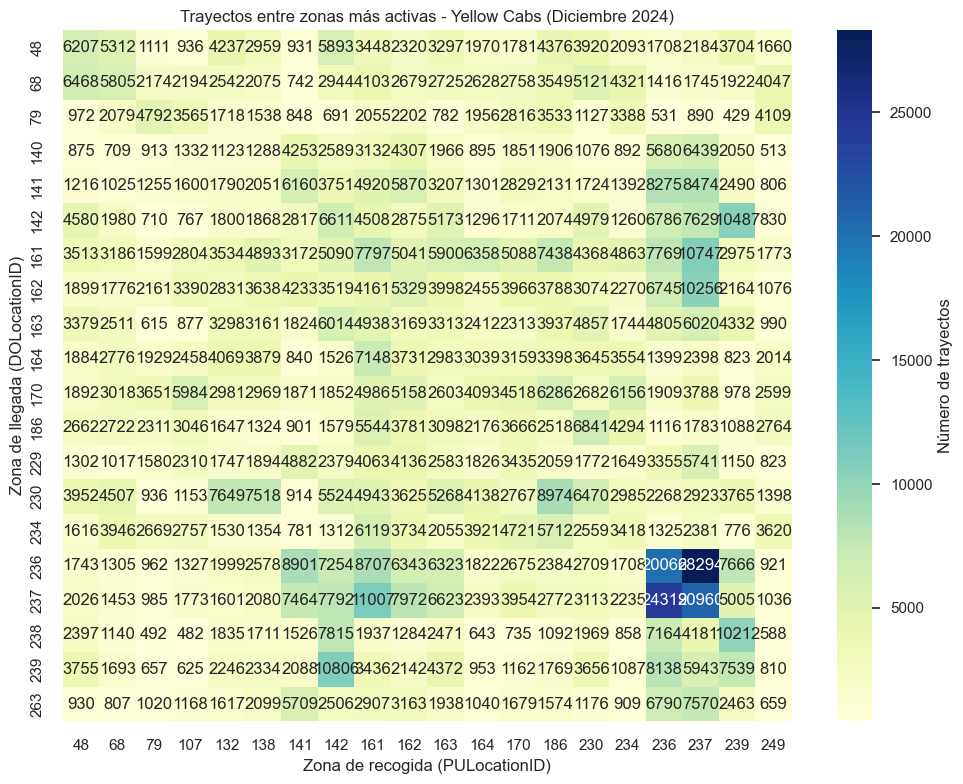

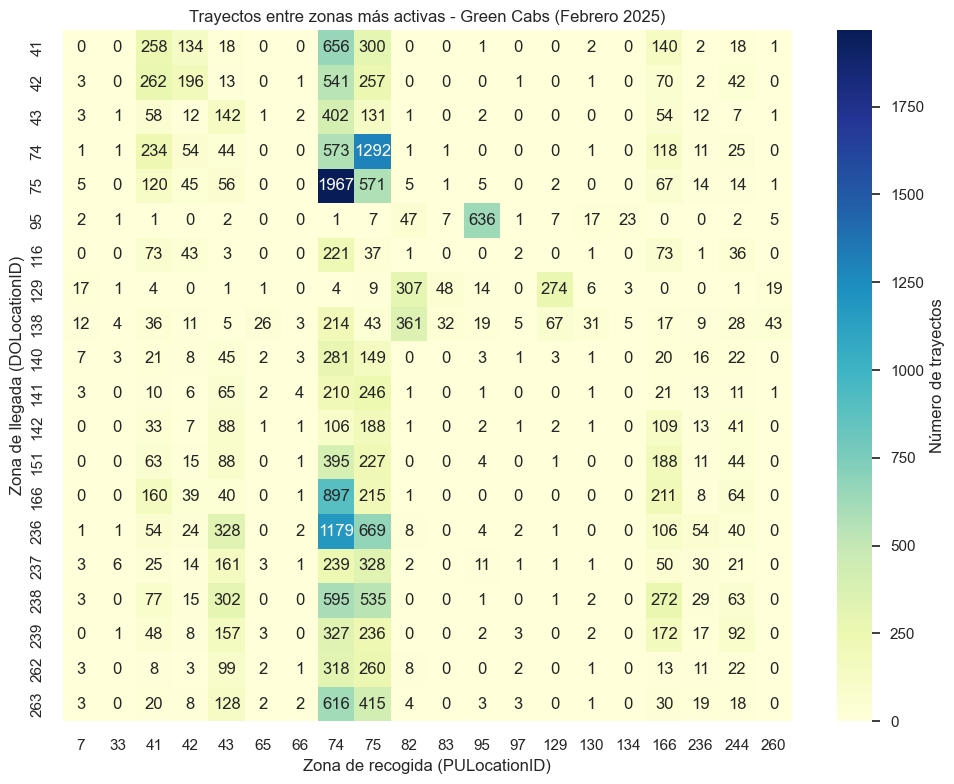

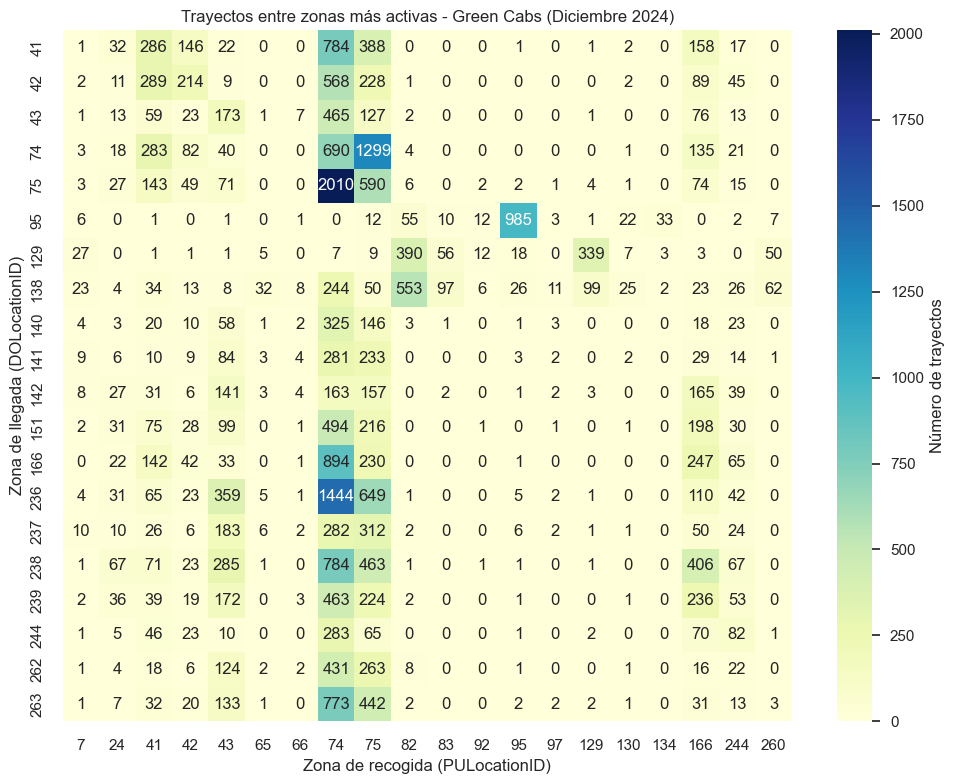

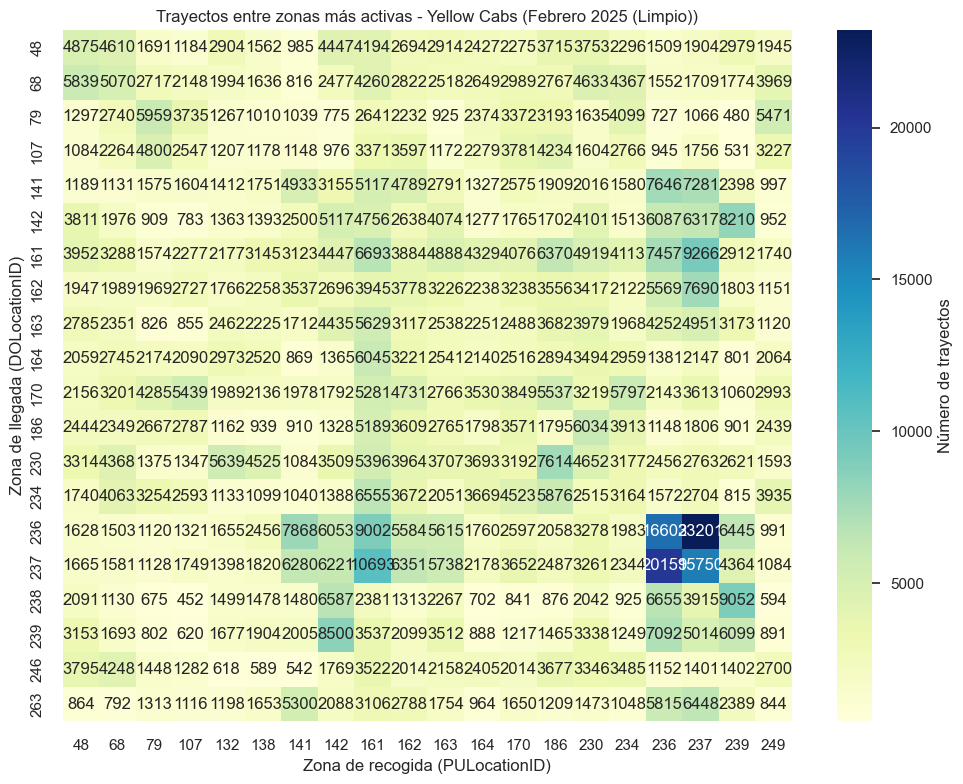

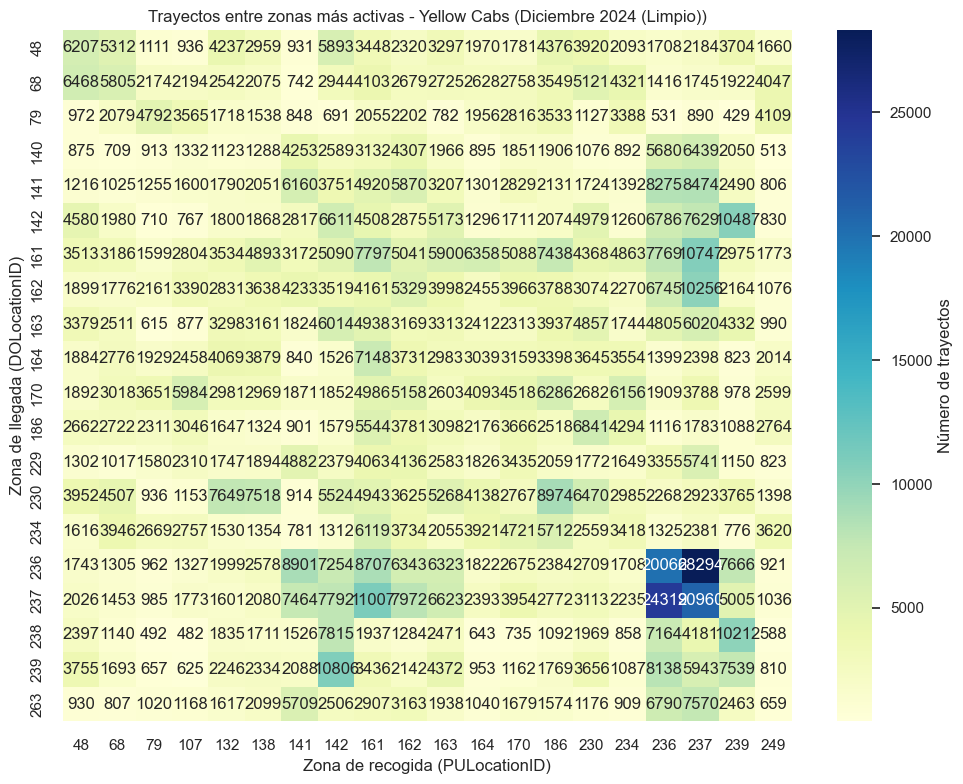

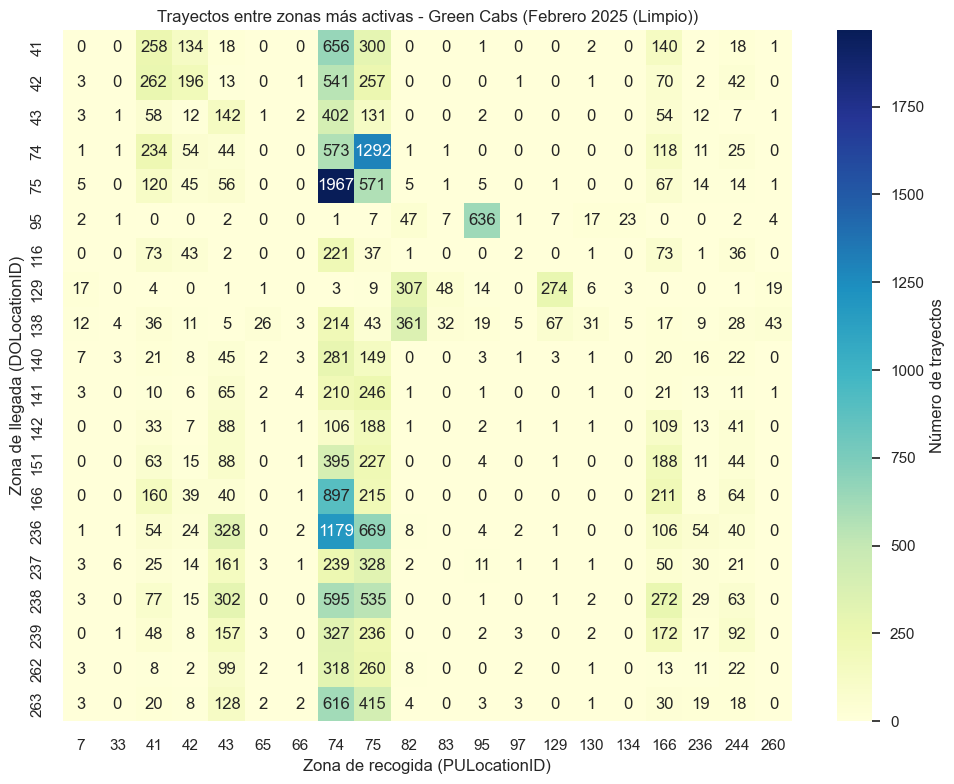

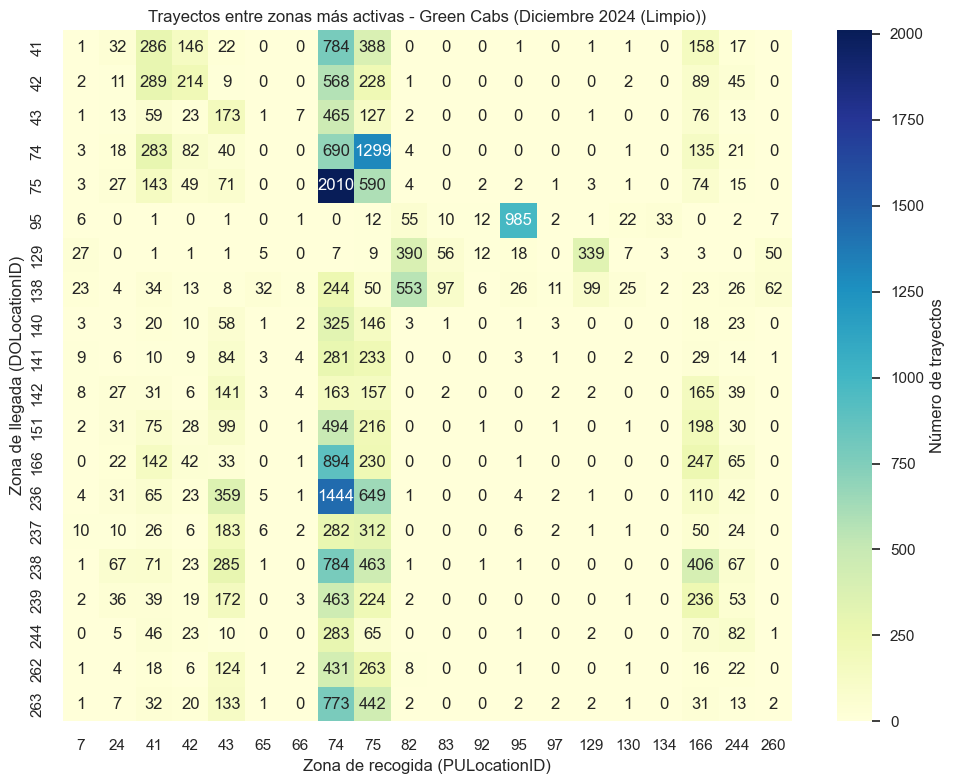

In [28]:
def plot_top_zones_heatmap(df, nombre_dataset, mes_label, top_n=20):
    """
    Genera un heatmap de trayectos entre las zonas más activas (recogida y destino).

    Parámetros:
    - df: DataFrame de viajes (con columnas PULocationID y DOLocationID)
    - nombre_dataset: nombre del dataset (ej. 'Yellow Cabs')
    - mes_label: etiqueta del mes (ej. 'Febrero 2025')
    - top_n: número de zonas más activas a considerar
    """

    # Agrupamos y contamos trayectos por combinación de zonas
    zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

    # Zonas más frecuentes en recogida y destino
    top_pickup = zonas.groupby('PULocationID')['count'].sum().nlargest(top_n).index
    top_dropoff = zonas.groupby('DOLocationID')['count'].sum().nlargest(top_n).index

    # Filtramos combinaciones entre esas zonas
    zonas_top = zonas[
        zonas['PULocationID'].isin(top_pickup) &
        zonas['DOLocationID'].isin(top_dropoff)
    ]

    # Creamos la matriz pivot para heatmap
    pivot = zonas_top.pivot(index='DOLocationID', columns='PULocationID', values='count').fillna(0)

    # Graficamos
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap="YlGnBu", annot=True, fmt=".0f", cbar_kws={'label': 'Número de trayectos'})
    plt.title(f'Trayectos entre zonas más activas - {nombre_dataset} ({mes_label})')
    plt.xlabel('Zona de recogida (PULocationID)')
    plt.ylabel('Zona de llegada (DOLocationID)')
    plt.tight_layout()
    plt.show()

# Generamos heatmaps para los datasets de Febrero 2025 y Diciembre 2024 originales
plot_top_zones_heatmap(yellow_df_2025_02, "Yellow Cabs", "Febrero 2025")
plot_top_zones_heatmap(yellow_df_2024_12, "Yellow Cabs", "Diciembre 2024")
plot_top_zones_heatmap(green_df_2025_02, "Green Cabs", "Febrero 2025")
plot_top_zones_heatmap(green_df_2024_12, "Green Cabs", "Diciembre 2024")

# Generamos heatmaps para los datasets de Febrero 2025 y Diciembre 2024 Limpios
plot_top_zones_heatmap(normalized_datasets["Yellow Feb 2025"], "Yellow Cabs", "Febrero 2025 (Limpio)")  
plot_top_zones_heatmap(normalized_datasets["Yellow Dec 2024"], "Yellow Cabs", "Diciembre 2024 (Limpio)")
plot_top_zones_heatmap(normalized_datasets["Green Feb 2025"], "Green Cabs", "Febrero 2025 (Limpio)")
plot_top_zones_heatmap(normalized_datasets["Green Dec 2024"], "Green Cabs", "Diciembre 2024 (Limpio)")



### Visualización de trayectos entre las 5 zonas más populares

In [29]:
# Función para generar un diagrama de Sankey con las 5 zonas más populares

def plot_sankey_top5(df, nombre_dataset, mes_label):
    """
    Diagrama de Sankey con las 5 zonas más populares (origen + destino),
    usando etiquetas combinadas con ID y nombre de zona.
    """

    # Agrupar trayectos entre zonas
    zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

    # Obtener top 5 zonas más activas
    zonas_frecuentes = pd.concat([
        zonas.groupby('PULocationID')['count'].sum(),
        zonas.groupby('DOLocationID')['count'].sum()
    ]).groupby(level=0).sum().nlargest(5).index.tolist()

    # Filtrar trayectos entre esas zonas
    zonas_top5 = zonas[
        zonas['PULocationID'].isin(zonas_frecuentes) &
        zonas['DOLocationID'].isin(zonas_frecuentes)
    ]

    # Crear etiquetas como "[ID] Nombre"
    etiquetas = [f"{z} - {zona_nombres.get(z, 'Desconocido')}" for z in zonas_frecuentes]
    zona_idx = {zona: i for i, zona in enumerate(zonas_frecuentes)}

    # Mapear source, target, value
    source = zonas_top5['PULocationID'].map(zona_idx).tolist()
    target = zonas_top5['DOLocationID'].map(zona_idx).tolist()
    value = zonas_top5['count'].tolist()

    # Crear Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15, thickness=20,
            line=dict(color="black", width=0.5),
            label=etiquetas
        ),
        link=dict(source=source, target=target, value=value)
    )])

    fig.update_layout(
        title_text=f"Trayectos entre las 5 zonas más populares – {nombre_dataset} ({mes_label})",
        font_size=12
    )
    return fig


# Generamos diagramas de Sankey para los datasets de Febrero 2025 y Diciembre 2024 limpios
plot_sankey_top5(normalized_datasets["Yellow Feb 2025"], "Yellow Cabs", "Febrero 2025 (Limpio)").show()
plot_sankey_top5(normalized_datasets["Yellow Dec 2024"], "Yellow Cabs", "Diciembre 2024 (Limpio)").show()
plot_sankey_top5(normalized_datasets["Green Feb 2025"], "Green Cabs", "Febrero 2025 (Limpio)").show()
plot_sankey_top5(normalized_datasets["Green Dec 2024"], "Green Cabs", "Diciembre 2024 (Limpio)").show()

# Generamos diagramas de Sankey para los datasets de Febrero 2025 y Diciembre 2024 originales
""" plot_sankey_top5(yellow_df_2025_02, "Yellow Cabs", "Febrero 2025").show()
plot_sankey_top5(yellow_df_2024_12, "Yellow Cabs", "Diciembre 2024").show()
plot_sankey_top5(green_df_2025_02, "Green Cabs", "Febrero 2025").show()
plot_sankey_top5(green_df_2024_12, "Green Cabs", "Diciembre 2024").show() """



' plot_sankey_top5(yellow_df_2025_02, "Yellow Cabs", "Febrero 2025").show()\nplot_sankey_top5(yellow_df_2024_12, "Yellow Cabs", "Diciembre 2024").show()\nplot_sankey_top5(green_df_2025_02, "Green Cabs", "Febrero 2025").show()\nplot_sankey_top5(green_df_2024_12, "Green Cabs", "Diciembre 2024").show() '

### Visualización (heatmaps) de trayectos entre las 5 zonas más populares

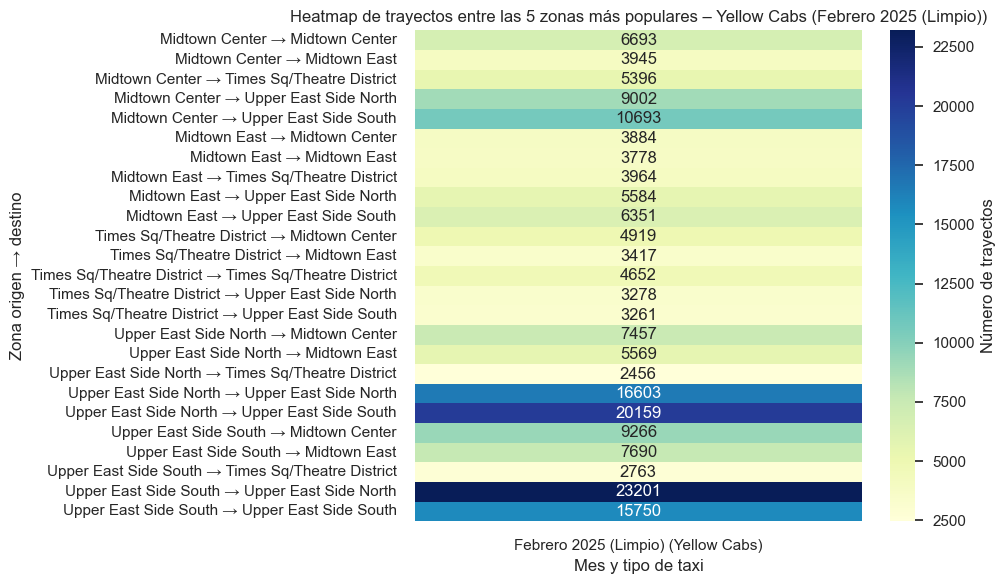

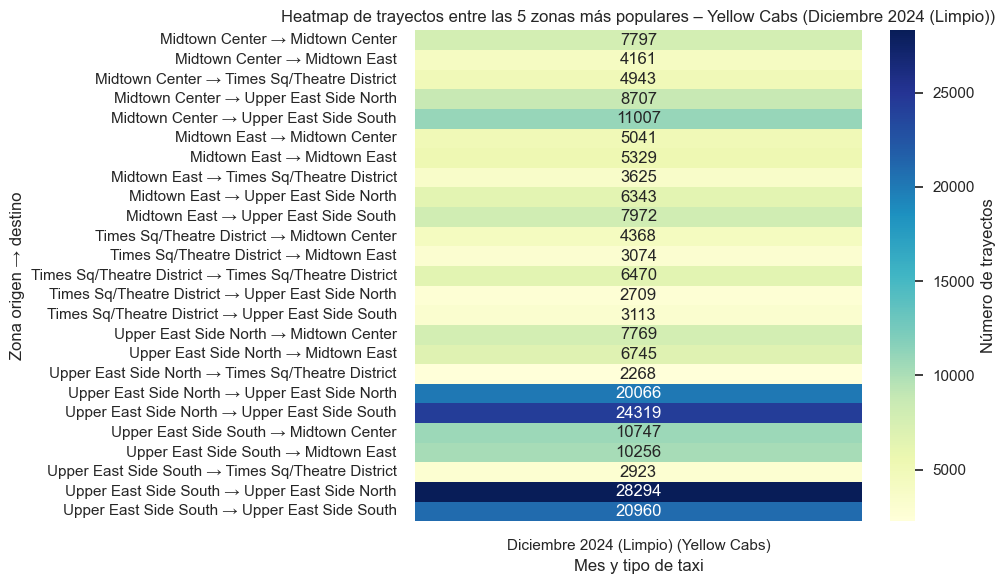

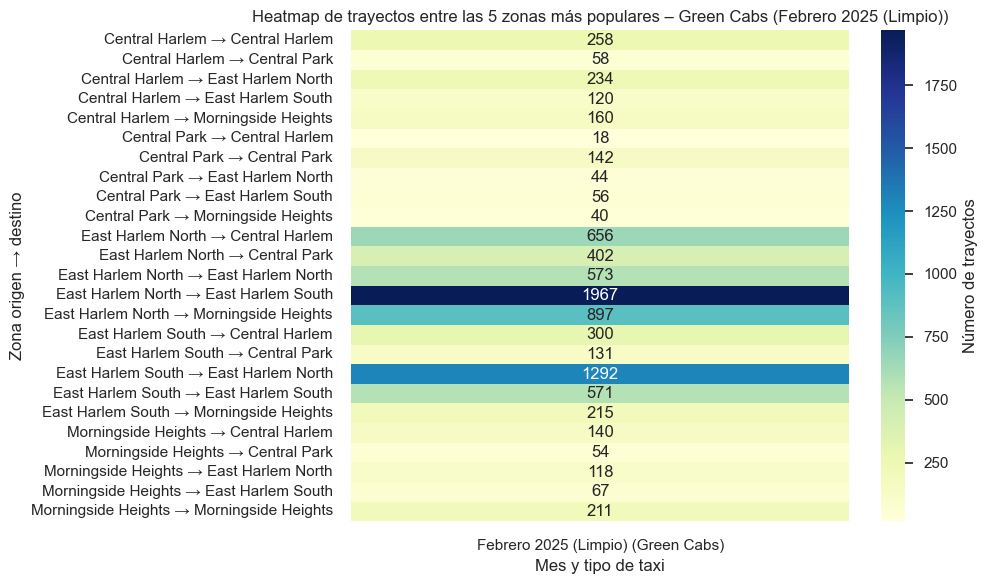

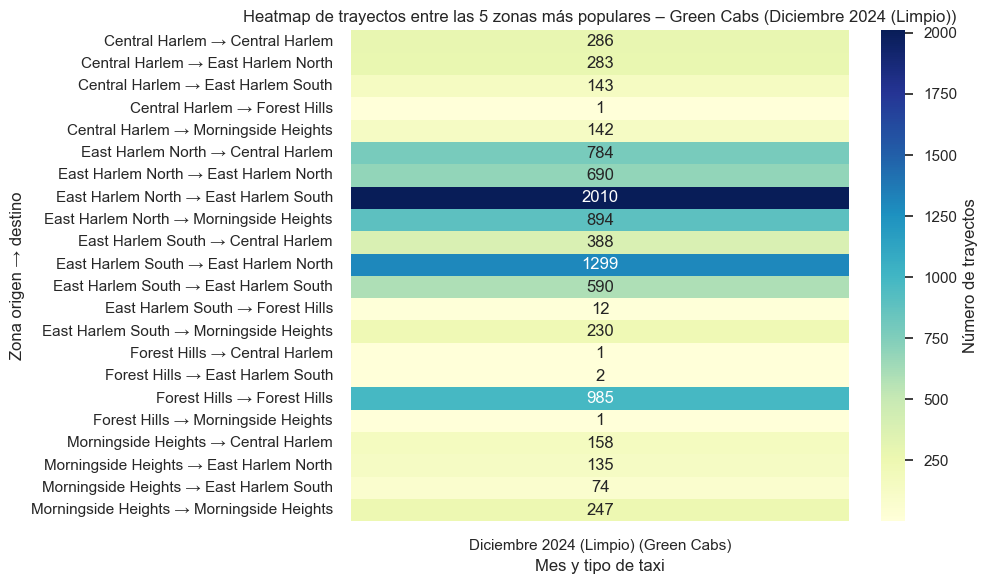

' plot_heatmap_top5(yellow_df_2025_02, "Yellow Cabs", "Febrero 2025")\nplot_heatmap_top5(yellow_df_2024_12, "Yellow Cabs", "Diciembre 2024")\nplot_heatmap_top5(green_df_2025_02, "Green Cabs", "Febrero 2025")\nplot_heatmap_top5(green_df_2024_12, "Green Cabs", "Diciembre 2024") '

In [30]:
def plot_heatmap_top5(df, nombre_dataset, mes_label):
    """
    Genera un heatmap con los trayectos entre las 5 zonas más populares (combinando origen y destino).

    Parámetros:
    - df: DataFrame con columnas PULocationID, DOLocationID
    - nombre_dataset: nombre del dataset (ej. 'Yellow Cabs')
    - mes_label: etiqueta del mes (ej. 'Febrero 2025')
    """

    # Agrupar trayectos
    zonas = df.groupby(['PULocationID', 'DOLocationID']).size().reset_index(name='count')

    # Zonas más activas (top 5 combinando origen y destino)
    zonas_frecuentes = pd.concat([
        zonas.groupby('PULocationID')['count'].sum(),
        zonas.groupby('DOLocationID')['count'].sum()
    ]).groupby(level=0).sum().nlargest(5).index.tolist()

    # Filtrar solo trayectos entre esas zonas
    zonas_top5 = zonas[
        zonas['PULocationID'].isin(zonas_frecuentes) &
        zonas['DOLocationID'].isin(zonas_frecuentes)
    ].copy()

    # Mapeo a nombres
    zonas_top5["Zona origen"] = zonas_top5["PULocationID"].map(zona_nombres)
    zonas_top5["Zona destino"] = zonas_top5["DOLocationID"].map(zona_nombres)

    # Crear índice de combinaciones origen → destino
    zonas_top5["Zona"] = zonas_top5["Zona origen"] + " → " + zonas_top5["Zona destino"]
    zonas_top5["Mes-Tipo"] = f"{mes_label} ({nombre_dataset})"

    # Pivot para heatmap
    pivot_df = zonas_top5.pivot(index="Zona", columns="Mes-Tipo", values="count").fillna(0)

    # Dibujar heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Número de trayectos'})
    plt.title(f"Heatmap de trayectos entre las 5 zonas más populares – {nombre_dataset} ({mes_label})")
    plt.ylabel("Zona origen → destino")
    plt.xlabel("Mes y tipo de taxi")
    plt.tight_layout()
    plt.show()

# Generamos heatmaps para los datasets de Febrero 2025 y Diciembre 2024 Limpios
plot_heatmap_top5(normalized_datasets["Yellow Feb 2025"], "Yellow Cabs", "Febrero 2025 (Limpio)")
plot_heatmap_top5(normalized_datasets["Yellow Dec 2024"], "Yellow Cabs", "Diciembre 2024 (Limpio)")
plot_heatmap_top5(normalized_datasets["Green Feb 2025"], "Green Cabs", "Febrero 2025 (Limpio)")
plot_heatmap_top5(normalized_datasets["Green Dec 2024"], "Green Cabs", "Diciembre 2024 (Limpio)")

# Generamos heatmaps para los datasets de Febrero 2025 y Diciembre 2024 originales
""" plot_heatmap_top5(yellow_df_2025_02, "Yellow Cabs", "Febrero 2025")
plot_heatmap_top5(yellow_df_2024_12, "Yellow Cabs", "Diciembre 2024")
plot_heatmap_top5(green_df_2025_02, "Green Cabs", "Febrero 2025")
plot_heatmap_top5(green_df_2024_12, "Green Cabs", "Diciembre 2024") """



# Segunda Parte: Análisis Cualitativo

2.1	¿Cuál es el trayecto en el que la relación precio/km es más alta? ¿Cuál es el trayecto en el que la relación tiempo/km es más alta? ¿Cuál es el trayecto en el que la relación precio/tiempo es más alta?

## Identificador de Outliers

In [85]:
def identificar_outliers(df):
    df = df.copy()
    """
    Detecta outliers en columnas relevantes de un dataset de taxis usando el método IQR.
    Devuelve un DataFrame con los registros que son outliers en al menos una métrica.

    Columnas evaluadas:
    - trip_distance
    - fare_amount
    - total_amount (si existe)
    - trip_duration (si se puede calcular)
    - precio_por_km (calculado)

    """
    # Calcular duración si no existe
    if "trip_duration_min" not in df.columns:
        if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
            df['trip_duration_min'] = (
                pd.to_datetime(df['tpep_dropoff_datetime']) - pd.to_datetime(df['tpep_pickup_datetime'])
            ).dt.total_seconds() / 60
        elif 'lpep_pickup_datetime' in df.columns and 'lpep_dropoff_datetime' in df.columns:
            df['trip_duration_min'] = (
                pd.to_datetime(df['lpep_dropoff_datetime']) - pd.to_datetime(df['lpep_pickup_datetime'])
            ).dt.total_seconds() / 60

    # Calcular precio por km si hay datos disponibles
    if 'fare_amount' in df.columns and 'trip_distance' in df.columns:
        df = df[df['trip_distance'] > 0]
        df['fare_per_km'] = df['fare_amount'] / df['trip_distance']


    # Columnas a evaluar
    columnas = ['trip_distance', 'fare_amount', 'trip_duration_min', 'fare_per_km']
    columnas = [col for col in columnas if col in df.columns]

    outlier_flags = pd.DataFrame(index=df.index)

    resumen = []

    for col in columnas:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lim_inf = Q1 - 1.5 * IQR
        lim_sup = Q3 + 1.5 * IQR

        flag = (df[col] < lim_inf) | (df[col] > lim_sup)
        outlier_flags[col + '_outlier'] = flag

        resumen.append((col, flag.sum(), lim_inf, lim_sup))

    # Combinar los flags para obtener las filas que son outliers en al menos una métrica
    outlier_rows = df[outlier_flags.any(axis=1)].copy()
    outlier_rows['Outlier en'] = outlier_flags[outlier_flags.any(axis=1)].apply(
        lambda x: ', '.join(x.index[x]), axis=1
    )

    # Mostrar resumen
    print("Resumen de outliers detectados:")
    for col, count, low, high in resumen:
        print(f"- {col}: {count} outliers (fuera de [{low:.2f}, {high:.2f}])")

    return outlier_rows

# Identificar outliers en los datasets de Febrero 2025 y Diciembre 2024 limpios
outliers_yellow_feb = identificar_outliers(normalized_datasets["Yellow Feb 2025"])
outliers_yellow_dic = identificar_outliers(normalized_datasets["Yellow Dec 2024"])
outliers_green_feb = identificar_outliers(normalized_datasets["Green Feb 2025"])
outliers_green_dic = identificar_outliers(normalized_datasets["Green Dec 2024"])

# Identificar outliers en los datasets de Febrero 2025 y Diciembre 2024 originales
""" outliers_yellow_feb = identificar_outliers(yellow_df_2025_02)
outliers_yellow_dic = identificar_outliers(yellow_df_2024_12)
outliers_green_feb = identificar_outliers(green_df_2025_02)
outliers_green_dic = identificar_outliers(green_df_2024_12) """




Resumen de outliers detectados:
- trip_distance: 201675 outliers (fuera de [-2.69, 9.79])
- fare_amount: 158267 outliers (fuera de [-5.75, 47.45])
- trip_duration_min: 114932 outliers (fuera de [-4.04, 40.42])
- fare_per_km: 37587 outliers (fuera de [1.63, 10.46])
Resumen de outliers detectados:
- trip_distance: 176955 outliers (fuera de [-2.58, 9.54])
- fare_amount: 89746 outliers (fuera de [-8.20, 53.40])
- trip_duration_min: 87912 outliers (fuera de [-7.87, 49.52])
- fare_per_km: 73712 outliers (fuera de [1.20, 11.97])
Resumen de outliers detectados:
- trip_distance: 2103 outliers (fuera de [-0.95, 6.78])
- fare_amount: 1427 outliers (fuera de [-0.15, 36.25])
- trip_duration_min: 1148 outliers (fuera de [-1.46, 32.88])
- fare_per_km: 569 outliers (fuera de [2.90, 9.45])
Resumen de outliers detectados:
- trip_distance: 2524 outliers (fuera de [-0.98, 6.86])
- fare_amount: 2004 outliers (fuera de [-1.20, 38.00])
- trip_duration_min: 1833 outliers (fuera de [-2.78, 35.43])
- fare_per_k

' outliers_yellow_feb = identificar_outliers(yellow_df_2025_02)\noutliers_yellow_dic = identificar_outliers(yellow_df_2024_12)\noutliers_green_feb = identificar_outliers(green_df_2025_02)\noutliers_green_dic = identificar_outliers(green_df_2024_12) '

##  Limpia un DataFrame eliminando registros con incoherencias entre distancia y precio. 

In [86]:
# Limpiar los datasets originales de Febrero 2025 y Diciembre 2024
def limpiar_dataset_con_regresion(df, z_thresh=3.0):
    """
    Elimina registros anómalos basados en una regresión lineal entre trip_distance y fare_amount.
    Aquellos con residuos (error entre predicho y real) muy altos, serán descartados.

    Parámetros:
    - df: DataFrame original
    - z_thresh: umbral de Z-score de residuos para considerar un punto como outlier

    Retorna:
    - DataFrame limpio, sin outliers
    """
    df = df.copy()

    # 1. Filtrar registros válidos
    df = df[
        df["trip_distance"].notnull() & 
        df["fare_amount"].notnull() & 
        (df["trip_distance"] > 0) & 
        (df["fare_amount"] > 0)
    ]

    # 2. Variables independientes y dependientes
    X = df[["trip_distance"]].values
    y = df["fare_amount"].values

    # 3. Ajustar modelo de regresión lineal
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)

    # 4. Calcular residuos y z-score
    residuos = y - y_pred
    z_residuos = zscore(residuos)

    # 5. Eliminar outliers
    df["residuo_z"] = z_residuos
    df_limpio = df[np.abs(df["residuo_z"]) <= z_thresh].drop(columns=["residuo_z"])

    return df_limpio.reset_index(drop=True)






## Ejecutar Limpiezas

### limpiar_dataset_con_regresion

In [87]:
# Aplicar la limpieza de outliers y relaciones anómalas
normalized_datasets["Yellow Feb 2025"] = limpiar_dataset_con_regresion(normalized_datasets["Yellow Feb 2025"])
normalized_datasets["Yellow Dec 2024"] = limpiar_dataset_con_regresion(normalized_datasets["Yellow Dec 2024"])
normalized_datasets["Green Feb 2025"] = limpiar_dataset_con_regresion(normalized_datasets["Green Feb 2025"])
normalized_datasets["Green Dec 2024"] = limpiar_dataset_con_regresion(normalized_datasets["Green Dec 2024"])

In [ ]:
# tabla comparativa de longitud de los datasets antes y después de la limpieza
print("Longitud de los datasets originales y normalizados:")
print("--------------------------------------------------------------------------")
print("Nombre del dataset\tLongitud original\tLongitud normalizada")
print("--------------------------------------------------------------------------")
print(f"Yellow Feb 2025\t\t{len(yellow_df_2025_02)}\t\t\t{len(normalized_datasets['Yellow Feb 2025'])}")
print(f"Yellow Dec 2024\t\t{len(yellow_df_2024_12)}\t\t\t{len(normalized_datasets['Yellow Dec 2024'])}")
print(f"Green Feb 2025\t\t{len(green_df_2025_02)}\t\t\t{len(normalized_datasets['Green Feb 2025'])}")
print(f"Green Dec 2024\t\t{len(green_df_2024_12)}\t\t\t{len(normalized_datasets['Green Dec 2024'])}")
print("--------------------------------------------------------------------------")

## Trayecto con mayor precio por km

In [88]:
def trayecto_mayor_precio_por_km(datasets, nombres):
    """
    Encuentra el trayecto con la mayor relación precio/km para cada dataset
    y también a nivel global, usando nombres reales de zona.
    """

    # 2. Lista donde se almacenarán los resultados por dataset
    resumen = []

    # 3. Variable para guardar el trayecto con mayor precio/km global (entre todos los datasets)
    global_max = None

    # 4. Iteramos por cada dataset y su nombre
    for df, nombre in zip(datasets, nombres):
        df = df.copy()  # Copiamos el DataFrame para no modificar el original

        # 5. Filtramos viajes con distancia y precio positivos
        df = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

        # 6. Calculamos la relación precio/km para cada fila
        df["fare_per_km"] = df["fare_amount"] / df["trip_distance"]

        # 7. Obtenemos el trayecto con mayor valor de precio/km
        top = df.loc[df["fare_per_km"].idxmax()]

        # 8. Añadimos el resultado al resumen, con nombre legible de origen y destino
        resumen.append({
            "Dataset": nombre,
            "Origen": f"{int(top['PULocationID'])} - {zona_nombres.get(top['PULocationID'], 'Desconocido')}",
            "Destino": f"{int(top['DOLocationID'])} - {zona_nombres.get(top['DOLocationID'], 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"]
        })

        # 9. Comparamos con el global: si es el primero o el más alto hasta ahora, lo guardamos
        if global_max is None or top["fare_per_km"] > global_max["fare_per_km"]:
            global_max = top
            global_name = nombre

    # 10. Añadimos también el trayecto con precio/km más alto del conjunto global
    resumen.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{int(global_max['PULocationID'])} - {zona_nombres.get(global_max['PULocationID'], 'Desconocido')}",
        "Destino": f"{int(global_max['DOLocationID'])} - {zona_nombres.get(global_max['DOLocationID'], 'Desconocido')}",
        "Distancia (mi)": global_max["trip_distance"],
        "Precio ($)": global_max["fare_amount"],
        "Precio/km ($)": global_max["fare_per_km"]
    })

    # 11. Devolvemos los resultados como un DataFrame
    return pd.DataFrame(resumen)


# Ejecutar la función con los datos limpios
df_resultado_precio_km_limpios = trayecto_mayor_precio_por_km(
    [
        normalized_datasets["Yellow Feb 2025"], 
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"], 
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)
# Visualizar los resultados
display(df_resultado_precio_km_limpios)



,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,Yellow Feb 2025,249 - West Village,90 - Flatiron,0.15,7.280009,48.533392
1,Yellow Dec 2024,68 - East Chelsea,90 - Flatiron,0.16,7.966483,49.790517
2,Green Feb 2025,97 - Fort Greene,66 - DUMBO/Vinegar Hill,1.60,22.600000,14.125000
3,Green Dec 2024,157 - Maspeth,80 - East Williamsburg,1.51,24.000000,15.894040
4,GLOBAL (Yellow Dec 2024),68 - East Chelsea,90 - Flatiron,0.16,7.966483,49.790517


## Trayecto con la relación tiempo/km más alta

In [101]:
def trayecto_mayor_duracion_por_km(datasets, nombres):
    """
    Encuentra el trayecto con mayor duración por kilómetro para cada dataset
    y también a nivel global, incluyendo nombres de zona.

    Parámetros:
        datasets: lista de DataFrames
        nombres: lista de nombres para cada dataset

    Retorna:
        DataFrame resumen con los trayectos más lentos (min/km)
    """
    resumen = []
    global_max = None

    for df, nombre in zip(datasets, nombres):
        df = df.copy()

        # Detectar columnas de datetime
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]

        if pickup_cols and dropoff_cols:
            pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
            dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        else:
            continue

        # Calcular duración en minutos
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        # Filtrar registros válidos
        df = df[(df["trip_distance"] > 0) & (df["duration_min"] > 0)].copy()

        # Duración por kilómetro
        df["min_per_km"] = df["duration_min"] / df["trip_distance"]

        if df.empty:
            continue

        top = df.loc[df["min_per_km"].idxmax()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["duration_min"],
            "Min/km": top["min_per_km"]
        })

        if global_max is None or top["min_per_km"] > global_max["min_per_km"]:
            global_max = top
            global_name = nombre

    # Global
    origen_id = int(global_max["PULocationID"])
    destino_id = int(global_max["DOLocationID"])
    resumen.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
        "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
        "Distancia (mi)": global_max["trip_distance"],
        "Duración (min)": global_max["duration_min"],
        "Min/km": global_max["min_per_km"]
    })

    return pd.DataFrame(resumen)


df_resultado_tiempo_por_km = trayecto_mayor_duracion_por_km(
    [
        normalized_datasets["Yellow Feb 2025"],
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"],
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)
display(df_resultado_tiempo_por_km)



,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,Yellow Feb 2025,238 - Upper West Side North,236 - Upper East Side North,1.50,1437.383333,958.255556
1,Yellow Dec 2024,107 - Gramercy,193 - Queensbridge/Ravenswood,1.68,4288.716667,2552.807540
2,Green Feb 2025,74 - East Harlem North,152 - Manhattanville,1.50,1390.416667,926.944444
3,Green Dec 2024,166 - Morningside Heights,239 - Upper West Side South,1.50,1425.500000,950.333333
4,GLOBAL (Yellow Dec 2024),107 - Gramercy,193 - Queensbridge/Ravenswood,1.68,4288.716667,2552.807540


## Trayecto con relación precio/tiempo más alta

In [102]:
def trayecto_mayor_precio_por_minuto(datasets, nombres):
    """
    Encuentra el trayecto con mayor relación precio/tiempo para cada dataset
    (es decir, el mayor coste por minuto), e identifica también el global.

    Parámetros:
        datasets: lista de DataFrames
        nombres: lista de nombres de los datasets

    Retorna:
        DataFrame con los trayectos más caros por minuto
    """
    resumen = []
    global_max = None

    for df, nombre in zip(datasets, nombres):
        df = df.copy()

        # Detectar columnas de tiempo
        pickup_cols = [col for col in df.columns if 'pickup' in col and 'datetime' in col]
        dropoff_cols = [col for col in df.columns if 'drop' in col and 'datetime' in col]
        if not pickup_cols or not dropoff_cols:
            continue

        # Calcular duración en minutos
        pickup = pd.to_datetime(df[pickup_cols[0]], errors='coerce')
        dropoff = pd.to_datetime(df[dropoff_cols[0]], errors='coerce')
        df["duration_min"] = (dropoff - pickup).dt.total_seconds() / 60

        # Filtrar registros válidos
        df = df[(df["duration_min"] > 0) & (df["fare_amount"] > 0)].copy()

        # Calcular $ por minuto
        df["usd_per_min"] = df["fare_amount"] / df["duration_min"]

        if df.empty:
            continue

        top = df.loc[df["usd_per_min"].idxmax()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resumen.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": top["duration_min"],
            "Precio ($)": top["fare_amount"],
            "$/min": top["usd_per_min"]
        })

        if global_max is None or top["usd_per_min"] > global_max["usd_per_min"]:
            global_max = top
            global_name = nombre

    # Agregar el caso global
    origen_id = int(global_max["PULocationID"])
    destino_id = int(global_max["DOLocationID"])
    resumen.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
        "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
        "Duración (min)": global_max["duration_min"],
        "Precio ($)": global_max["fare_amount"],
        "$/min": global_max["usd_per_min"]
    })

    return pd.DataFrame(resumen)


df_resultado_precio_minuto = trayecto_mayor_precio_por_minuto(
    [
        normalized_datasets["Yellow Feb 2025"],
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"],
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)

display(df_resultado_precio_minuto)


,Dataset,Origen,Destino,Duración (min),Precio ($),$/min
0,Yellow Feb 2025,138 - LaGuardia Airport,195 - Red Hook,0.033333,61.8,1854.000000
1,Yellow Dec 2024,74 - East Harlem North,69 - East Concourse/Concourse Village,0.033333,20.5,615.000000
2,Green Feb 2025,56 - Corona,70 - East Elmhurst,0.483333,8.7,18.000000
3,Green Dec 2024,42 - Central Harlem North,152 - Manhattanville,5.066667,40.0,7.894737
4,GLOBAL (Yellow Feb 2025),138 - LaGuardia Airport,195 - Red Hook,0.033333,61.8,1854.000000


## 2.2	¿Cuál es el trayecto en el que la relación precio/km es más baja? 

In [103]:
def trayecto_menor_precio_por_km(datasets, nombres):
    """
    Encuentra el trayecto con menor relación precio/km para cada dataset
    y también el trayecto global con la relación más baja.
    """

    resultados = []
    global_min = None

    for df, nombre in zip(datasets, nombres):
        df = df.copy()
        df = df[(df["trip_distance"] > 0) & (df["fare_amount"] > 0)]

        df["fare_per_km"] = df["fare_amount"] / df["trip_distance"]

        if df.empty:
            continue

        top = df.loc[df["fare_per_km"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Precio ($)": top["fare_amount"],
            "Precio/km ($)": top["fare_per_km"]
        })

        if global_min is None or top["fare_per_km"] < global_min["fare_per_km"]:
            global_min = top
            global_name = nombre

    # Trayecto global con el precio/km más bajo
    origen_id = int(global_min["PULocationID"])
    destino_id = int(global_min["DOLocationID"])

    resultados.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
        "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
        "Distancia (mi)": global_min["trip_distance"],
        "Precio ($)": global_min["fare_amount"],
        "Precio/km ($)": global_min["fare_per_km"]
    })

    return pd.DataFrame(resultados)

df_menor_precio_km = trayecto_menor_precio_por_km(
    [
        normalized_datasets["Yellow Feb 2025"],
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"],
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)

display(df_menor_precio_km)


,Dataset,Origen,Destino,Distancia (mi),Precio ($),Precio/km ($)
0,Yellow Feb 2025,151 - Manhattan Valley,166 - Morningside Heights,1.70,5.1,3.000000
1,Yellow Dec 2024,113 - Greenwich Village North,21 - Bensonhurst East,12.50,37.5,3.000000
2,Green Feb 2025,76 - East New York,222 - Starrett City,1.83,5.8,3.169399
3,Green Dec 2024,74 - East Harlem North,236 - Upper East Side North,2.63,8.0,3.041825
4,GLOBAL (Yellow Feb 2025),151 - Manhattan Valley,166 - Morningside Heights,1.70,5.1,3.000000


## ¿Cuál es el trayecto en el que la relación tiempo/km es más baja? 

In [104]:
def trayecto_menor_tiempo_por_km(datasets, nombres):
    """
    Encuentra el trayecto con menor relación tiempo/km (minutos por milla) para cada dataset,
    así como el trayecto global con la menor relación.
    """

    resultados = []
    global_min = None

    for df, nombre in zip(datasets, nombres):
        df = df.copy()
        df = df[(df["trip_distance"] > 0)]

        if "trip_duration_min" not in df.columns:
            if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["tpep_dropoff_datetime"]) - pd.to_datetime(df["tpep_pickup_datetime"])
                ).dt.total_seconds() / 60
            elif 'lpep_pickup_datetime' in df.columns and 'lpep_dropoff_datetime' in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["lpep_dropoff_datetime"]) - pd.to_datetime(df["lpep_pickup_datetime"])
                ).dt.total_seconds() / 60

        df = df[(df["trip_duration_min"] > 0)]
        df["min_per_km"] = df["trip_duration_min"] / df["trip_distance"]

        if df.empty:
            continue

        top = df.loc[df["min_per_km"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Distancia (mi)": top["trip_distance"],
            "Duración (min)": top["trip_duration_min"],
            "Min/km": top["min_per_km"]
        })

        if global_min is None or top["min_per_km"] < global_min["min_per_km"]:
            global_min = top
            global_name = nombre

    # Trayecto global con el menor tiempo/km
    origen_id = int(global_min["PULocationID"])
    destino_id = int(global_min["DOLocationID"])

    resultados.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
        "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
        "Distancia (mi)": global_min["trip_distance"],
        "Duración (min)": global_min["trip_duration_min"],
        "Min/km": global_min["min_per_km"]
    })

    return pd.DataFrame(resultados)

df_menor_tiempo_km = trayecto_menor_tiempo_por_km(
    [
        normalized_datasets["Yellow Feb 2025"],
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"],
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)

display(df_menor_tiempo_km)


,Dataset,Origen,Destino,Distancia (mi),Duración (min),Min/km
0,Yellow Feb 2025,138 - LaGuardia Airport,195 - Red Hook,13.08,0.033333,0.002548
1,Yellow Dec 2024,138 - LaGuardia Airport,48 - Clinton East,9.12,0.133333,0.014620
2,Green Feb 2025,56 - Corona,70 - East Elmhurst,1.73,0.483333,0.279383
3,Green Dec 2024,42 - Central Harlem North,152 - Manhattanville,6.87,5.066667,0.737506
4,GLOBAL (Yellow Feb 2025),138 - LaGuardia Airport,195 - Red Hook,13.08,0.033333,0.002548


## ¿Cuál es el trayecto en el que la relación precio/tiempo es más baja?

In [105]:
def trayecto_menor_precio_por_minuto(datasets, nombres):
    """
    Encuentra el trayecto con menor relación precio/tiempo (USD por minuto) para cada dataset
    y el trayecto global con la menor relación.
    """

    resultados = []
    global_min = None

    for df, nombre in zip(datasets, nombres):
        df = df.copy()
        df = df[(df["fare_amount"] > 0)]

        # Calcular duración si no existe
        if "trip_duration_min" not in df.columns:
            if 'tpep_pickup_datetime' in df.columns and 'tpep_dropoff_datetime' in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["tpep_dropoff_datetime"]) - pd.to_datetime(df["tpep_pickup_datetime"])
                ).dt.total_seconds() / 60
            elif 'lpep_pickup_datetime' in df.columns and 'lpep_dropoff_datetime' in df.columns:
                df["trip_duration_min"] = (
                    pd.to_datetime(df["lpep_dropoff_datetime"]) - pd.to_datetime(df["lpep_pickup_datetime"])
                ).dt.total_seconds() / 60

        df = df[(df["trip_duration_min"] > 0)]
        df["usd_per_min"] = df["fare_amount"] / df["trip_duration_min"]

        if df.empty:
            continue

        top = df.loc[df["usd_per_min"].idxmin()]
        origen_id = int(top["PULocationID"])
        destino_id = int(top["DOLocationID"])

        resultados.append({
            "Dataset": nombre,
            "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
            "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
            "Duración (min)": top["trip_duration_min"],
            "Precio ($)": top["fare_amount"],
            "Precio/min ($)": top["usd_per_min"]
        })

        if global_min is None or top["usd_per_min"] < global_min["usd_per_min"]:
            global_min = top
            global_name = nombre

    origen_id = int(global_min["PULocationID"])
    destino_id = int(global_min["DOLocationID"])

    resultados.append({
        "Dataset": f"GLOBAL ({global_name})",
        "Origen": f"{origen_id} - {zona_nombres.get(origen_id, 'Desconocido')}",
        "Destino": f"{destino_id} - {zona_nombres.get(destino_id, 'Desconocido')}",
        "Duración (min)": global_min["trip_duration_min"],
        "Precio ($)": global_min["fare_amount"],
        "Precio/min ($)": global_min["usd_per_min"]
    })

    return pd.DataFrame(resultados)

df_menor_precio_por_minuto = trayecto_menor_precio_por_minuto(
    [
        normalized_datasets["Yellow Feb 2025"],
        normalized_datasets["Yellow Dec 2024"],
        normalized_datasets["Green Feb 2025"],
        normalized_datasets["Green Dec 2024"]
    ],
    ["Yellow Feb 2025", "Yellow Dec 2024", "Green Feb 2025", "Green Dec 2024"]
)

display(df_menor_precio_por_minuto)


,Dataset,Origen,Destino,Duración (min),Precio ($),Precio/min ($)
0,Yellow Feb 2025,263 - Yorkville West,140 - Lenox Hill East,1437.633333,8.6,0.005982
1,Yellow Dec 2024,107 - Gramercy,193 - Queensbridge/Ravenswood,4288.716667,10.7,0.002495
2,Green Feb 2025,74 - East Harlem North,75 - East Harlem South,1388.950000,9.3,0.006696
3,Green Dec 2024,74 - East Harlem North,75 - East Harlem South,1387.850000,10.0,0.007205
4,GLOBAL (Yellow Dec 2024),107 - Gramercy,193 - Queensbridge/Ravenswood,4288.716667,10.7,0.002495


In [110]:
# mostrar las columnas de los datasets
print("Columnas de los datasets:")
print("--------------------------------------------------------------------------")
print("Nombre del dataset\tColumnas")
print("--------------------------------------------------------------------------")
print(f"Yellow Feb 2025\t\t{normalized_datasets['Yellow Feb 2025'].columns.tolist()}")

Columnas de los datasets:
--------------------------------------------------------------------------
Nombre del dataset	Columnas
--------------------------------------------------------------------------
Yellow Feb 2025		['VendorID', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tips', 'tolls', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee', 'cbd_congestion_fee', 'fare_per_km', 'corregido', 'trip_duration_min', 'location_valid']


## Evolución del tiempo medio de trayecto a lo largo del día

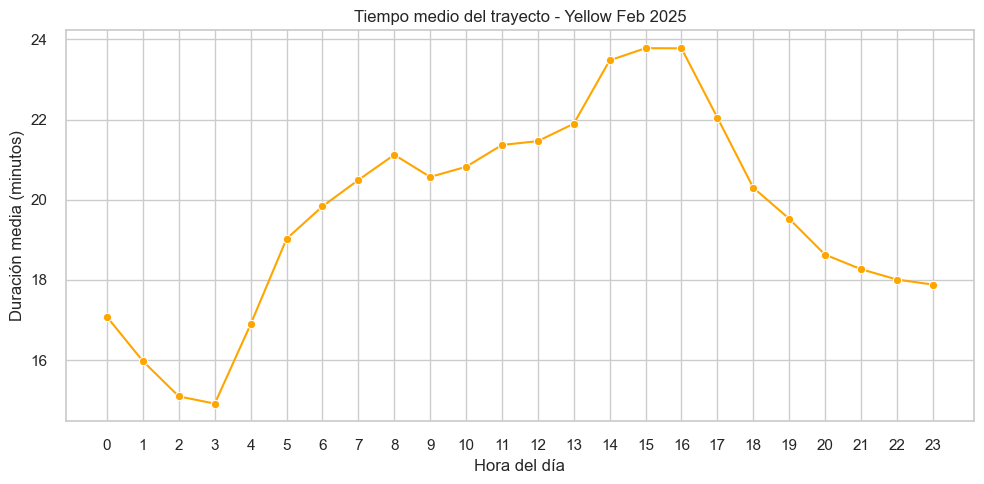

In [112]:
def plot_tiempo_medio_por_hora(df, titulo="Duración media del trayecto por hora"):
    """
    Grafica la duración media (minutos) del trayecto a lo largo del día.
    """
    df = df.copy()

    # Detectar columnas de fecha
    if 'pickup_datetime' in df.columns:
        df['hora'] = pd.to_datetime(df['pickup_datetime']).dt.hour
        df['duracion_min'] = (pd.to_datetime(df['dropoff_datetime']) - pd.to_datetime(df['pickup_datetime'])).dt.total_seconds() / 60
    else:
        print("No se encontró columna de pickup válida.")
        return

    df = df[df['duracion_min'] > 0]

    # Agrupar por hora
    media_por_hora = df.groupby('hora')['duracion_min'].mean()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="orange")
    plt.title(titulo)
    plt.xlabel("Hora del día")
    plt.ylabel("Duración media (minutos)")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_tiempo_medio_por_hora(normalized_datasets["Yellow Feb 2025"], "Tiempo medio del trayecto - Yellow Feb 2025")


## Muestra la evolución de la distancia media de trayecto a lo largo del día.

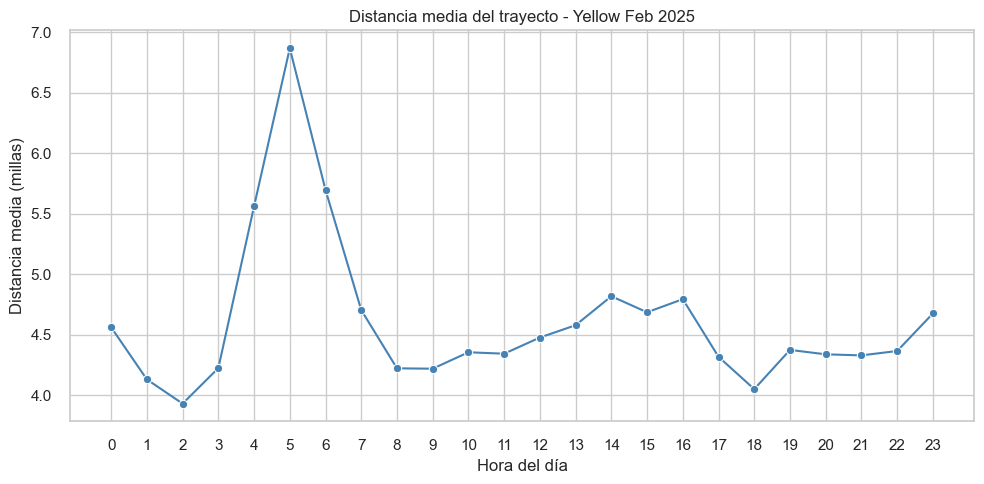

In [114]:
def plot_distancia_media_por_hora(df, titulo="Distancia media del trayecto por hora"):
    """
    Grafica la distancia media (millas) del trayecto a lo largo del día.
    """
    df = df.copy()

    # Detectar columnas de fecha
    if 'pickup_datetime' in df.columns:
        df['hora'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    else:
        print("No se encontró columna de pickup válida.")
        return

    df = df[df['trip_distance'] > 0]

    # Agrupar por hora
    media_por_hora = df.groupby('hora')['trip_distance'].mean()

    # Plot
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=media_por_hora.index, y=media_por_hora.values, marker="o", color="steelblue")
    plt.title(titulo)
    plt.xlabel("Hora del día")
    plt.ylabel("Distancia media (millas)")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_distancia_media_por_hora(normalized_datasets["Yellow Feb 2025"], "Distancia media del trayecto - Yellow Feb 2025")



## 2.4	Elige dos zonas cualesquiera de la ciudad y calcula la probabilidad de desplazarse de una zona a otra en menos de X minutos. (El valor X, así como las zonas deben ser fácilmente modificables).

In [116]:
def calcular_probabilidad_desplazamiento_rapido(df, origen, destino, umbral_min=10):
    """
    Calcula la probabilidad de que un trayecto entre dos zonas específicas dure menos de X minutos.

    Parámetros:
        - df: DataFrame de taxis (debe tener columnas pickup/dropoff y duración)
        - origen: ID de la zona de origen (int)
        - destino: ID de la zona de destino (int)
        - umbral_min: duración máxima para considerar un trayecto como rápido (por defecto 10 minutos)

    Retorna:
        - total_trayectos: número de trayectos encontrados entre origen y destino
        - probabilidad: proporción de trayectos con duración < umbral
    """
    df = df.copy()

    # Identificar las columnas de tiempo
    if 'pickup_datetime' in df.columns:
        pickup = pd.to_datetime(df['pickup_datetime'], errors='coerce')
        dropoff = pd.to_datetime(df['dropoff_datetime'], errors='coerce')
    else:
        print("No se encontró columna de pickup válida.")
        return None, None

    # Calcular duración en minutos
    df['duracion_min'] = (dropoff - pickup).dt.total_seconds() / 60

    # Filtrar trayectos entre las zonas dadas
    filtro = (df['PULocationID'] == origen) & (df['DOLocationID'] == destino)
    trayectos = df[filtro & (df['duracion_min'].notnull())]

    total = len(trayectos)
    if total == 0:
        print(f"No se encontraron trayectos de {origen} a {destino}.")
        return 0, 0.0

    rapidos = trayectos[trayectos['duracion_min'] < umbral_min]
    probabilidad = len(rapidos) / total

    print(f"Trayectos de {origen} → {destino} en menos de {umbral_min} minutos:")
    print(f"- Total: {total}")
    print(f"- Rápidos (< {umbral_min} min): {len(rapidos)}")
    print(f"- Probabilidad: {probabilidad:.2%}")

    return total, probabilidad

# Ejemplo: ¿Qué probabilidad hay de ir de Midtown Center (161) a West Chelsea (246) en menos de 8 minutos?
calcular_probabilidad_desplazamiento_rapido(
    normalized_datasets["Yellow Feb 2025"],
    origen=161,
    destino=246,
    umbral_min=8
)


Trayectos de 161 → 246 en menos de 8 minutos:
- Total: 2730
- Rápidos (< 8 min): 22
- Probabilidad: 0.81%


(2730, 0.00805860805860806)